### Importando bibliotecas

In [1]:
#from google.colab import drive

In [2]:
#utilitarias
import json
import pandas as pd
import numpy as np
from scipy import stats
from numpy import nan
import re

#graficas
import matplotlib as plt
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from pylab import rcParams

#imputação
from sklearn.impute import SimpleImputer

### Algumas configurações

In [3]:
# Set intial variables and constants
%config InlineBackend.figure_format='retina'

# Graph Designs
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

### Lendo dados

In [4]:
#drive.mount('/content/drive')

In [5]:
#path="/content/drive/MyDrive/onCase-TechnicalTest/analysis/data/eda_receitas_data/"
path="dataset/eda_receitas_data/"

In [6]:
from os import read
#read json
def readJsonFile():
  with open(path + "receitas.json", 'r') as datafile:
    data = json.load(datafile)
    return pd.DataFrame(data)

df = readJsonFile()

### Conhecendo o dataset

In [7]:
print('shape: ',df.shape,'\n')
df.head(3)

shape:  (20130, 11) 



,directions,fat,date,categories,calories,desc,protein,rating,title,ingredients,sodium
0,"[1. Place the stock, lentils, celery, carrot, ...",7.0,2006-09-01T04:00:00.000Z,"[Sandwich, Bean, Fruit, Tomato, turkey, Vegeta...",426.0,None,30.0,2.500,"Lentil, Apple, and Turkey Wrap","[4 cups low-sodium vegetable or chicken stock,...",559.0
1,[Combine first 9 ingredients in heavy medium s...,23.0,2004-08-20T04:00:00.000Z,"[Food Processor, Onion, Pork, Bake, Bastille D...",403.0,This uses the same ingredients found in boudin...,18.0,4.375,Boudin Blanc Terrine with Red Onion Confit,"[1 1/2 cups whipping cream, 2 medium onions, c...",1439.0
2,[In a large heavy saucepan cook diced fennel a...,7.0,2004-08-20T04:00:00.000Z,"[Soup/Stew, Dairy, Potato, Vegetable, Fennel, ...",165.0,None,6.0,3.750,Potato and Fennel Soup Hodge,"[1 fennel bulb (sometimes called anise), stalk...",165.0


In [8]:
#Show a recipe.
row = 1
for column in df.columns:
  print(column)
  print(df.iloc[row][column])
  print()

directions
['Combine first 9 ingredients in heavy medium saucepan. Add 3 shallots. Bring to simmer. Remove from heat, cover and let stand 30 minutes. Chill overnight.', 'Preheat oven to 325°F. Line 7-cup pâté or bread pan with plastic wrap. Melt butter in heavy small skillet over low heat. Add remaining 5 shallots. Cover and cook until very soft, stirring occasionally, about 15 minutes. Transfer to processor. Add pork, eggs, flour and Port and puree. Strain cream mixture, pressing on solids to extract as much liquid as possible. With processor running, add cream through feed tube and process just until combined with pork. Transfer to large bowl. Mix in currants.', 'Spoon mixture into prepared pan. Cover with foil. Place pan in large pan. Add boiling water to larger pan to within 1/2 inch of top of terrine. Bake until terrine begins to shrink from sides of pan and knife inserted into center comes out clean, about 1 1/2 hours. Uncover and cool on rack. Chill until cold. (Can be made 3 da

# Analise descritiva dos dados 

#### Identificando dados faltantes

In [9]:
def checkMissingValues(columns_):
  for column in columns_:
    missing = df[column].isnull().sum()
    print(column,' : ', missing)

print('\nNº Rows', len(df),'\n' ) 

checkMissingValues(df.columns)


Nº Rows 20130 

directions  :  19
fat  :  4222
date  :  19
categories  :  19
calories  :  4154
desc  :  6635
protein  :  4201
rating  :  30
title  :  19
ingredients  :  19
sodium  :  4156


In [10]:
# Verifing the rows with missing values in column title
print('shape: ', df[df['title'].isnull()].shape)
df[df['title'].isnull()].head(3)

shape:  (19, 11)


,directions,fat,date,categories,calories,desc,protein,rating,title,ingredients,sodium
1076,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1135,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1907,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Apagar as linhas com valores NaN na coluna título

In [11]:
# drop rows with missing values in the title column
df.dropna(subset=['title'], inplace=True)
checkMissingValues(df.columns)

directions  :  0
fat  :  4203
date  :  0
categories  :  0
calories  :  4135
desc  :  6616
protein  :  4182
rating  :  11
title  :  0
ingredients  :  0
sodium  :  4137


Ainda existe muitas células com valores faltantes, principalmente na coluna desc. No entanto a coluna desc não demostra relevância para a análise.
Neste momento é interessante analisar os valores faltantes nas colunas númericas (fat, calories, protein, rating e sodium).


### Trabalhando com as variáveis numéricas

Referente as variáveis numéricas, a variável fat é a que possui o maior número de valores faltantes (4203), enquanto que as variáveis calories, protein, e sodium, possuem 4135, 4182 e 4137, respectivamente. O próximo passo é verificar se as linhas com valores faltantes das  variáveis calories, protein e sodium, são as mesmas com valores faltantes na coluna da variável fat.

In [12]:
# checking if the missing values are located in the same columns
print('fat x all      : ', df[df[['fat','calories','protein','sodium']].isnull().sum(axis=1)==4].shape)
print('fat x calories : ', df[df[['fat','calories']].isnull().sum(axis=1)==2].shape)
print('fat x protein  : ', df[df[['fat','protein']].isnull().sum(axis=1)==2].shape)
print('fat x sodium   : ', df[df[['fat','sodium']].isnull().sum(axis=1)==2].shape)

fat x all      :  (4135, 11)
fat x calories :  (4135, 11)
fat x protein  :  (4179, 11)
fat x sodium   :  (4135, 11)


Analisando os valores faltantes das colunas calories, protein e sodium, pode se perceber que eles estão localizados majoritariamente nas mesmas linhas em que estão faltando valores na coluna *fat*, ou seja, as quatro colunas estão apresentando valores faltantes nas mesmas linhas. Desse modo, podemos excluir essas 4135 linhas que apresentam valores faltantes.

Para facilitar o trabalho com os variáveis numéricas, vamos adiciona-las em um novo dataframe.



#### Separando as variáveis numéricas

In [13]:
# getting only the numeric columns of the dataset
df_numVar = df[['fat', 'calories', 'protein', 'sodium', 'rating']]
subset_numericCols = ['fat','calories','protein','sodium']

</br>Exluindo as linhas com valores faltantes em todas as variáveis numéricas

In [14]:
df_numVar.dropna(how='all', subset=subset_numericCols, inplace=True)

print('shape: ',df_numVar.shape)
print('\nRows with NaN values in df_numVar')
print(df_numVar[df_numVar[['fat','protein','sodium','rating']].isnull().sum(axis=1)>0].shape)

shape:  (15976, 5)

Rows with NaN values in df_numVar
(80, 5)


/tmp/ipykernel_8554/357684895.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_numVar.dropna(how='all', subset=subset_numericCols, inplace=True)


Tendo em vista que o dataset numeric_columns possui 15976 linhas, as 80 linhas que apresentam valores faltantes, representam apenas 0.005 do dataset. Assim, é possivel inferir que a exclusão dessas linhas não irá interferir  nas analises e desenvolvimento de modelos de predição ou de classificação.

In [15]:
df_numVar.dropna(inplace=True)
df_numVar.shape

/tmp/ipykernel_8554/821990636.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_numVar.dropna(inplace=True)


(15896, 5)

#### Analisando dados numéricos


Vamos analisar os dados **núméricos** por meio da média, desvio padrão, quartis e valores máximos e mínimos.

In [16]:
df_numVar.describe().round(2)

,fat,calories,protein,sodium,rating
count,15896.00,15896.00,15896.00,15896.00,15896.00
mean,346.35,6338.84,100.15,6241.39,3.76
std,20438.73,359486.11,3839.59,333705.76,1.29
min,0.00,0.00,0.00,0.00,0.00
25%,7.00,199.00,3.00,81.00,3.75
50%,17.00,333.00,8.00,296.00,4.38
75%,33.00,587.00,27.00,713.00,4.38
max,1722763.00,30111218.00,236489.00,27675110.00,5.00


Algumas inferências:
*   A média de gordura **fat** das receitas é 346, a média de **calories** é 6338
, de **protein** 100 e de **sodium** 6241.
*   É estranho ter valores 'zero' para estas variáveis como aparece na linha de valores mínimos. Por esse motivo vamos excluir as linhas que contem zero em qualquer dessas colunas.




In [17]:
print('n linhas before: ',df_numVar.shape[0])

for column in subset_numericCols:
  df_numVar = df_numVar.loc[df_numVar[column] != 0]

print('n linhas after: ',df_numVar.shape[0])


n linhas before:  15896
n linhas after:  14390


Ao eliminar as linhas com valores zero em qualquer das colunas ['fat', 'calories', 'protein', 'sodium', 'rating'], o dataset passou de *15_896* para *14_390*, 

#### Identificando outliers

Funções implementadas para facilitar a identificação e exclusão dos outliers

In [18]:
# Function to find outliers using IQR
def find_outliers_IQR(df):
  q1=df.quantile(0.25)
  q3=df.quantile(0.75)
  IQR=q3-q1
  outliers = df[((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))]      
  return outliers

def drop_outliers_IQR(df, column):
  q1=df[column.name].quantile(0.25)
  q3=df[column.name].quantile(0.75)
  IQR=q3-q1
  
  not_outliers = df[~((df[column.name]<(q1-1.5*IQR)) | (df[column.name]>(q3+1.5*IQR)))]
  return not_outliers
  #outliers = find_outliers_IQR(df)
  #outliers_dropped = outliers.dropna().reset_index()
  #return outliers_dropped

def showBasicOutliersInfo(df, outliers):
  print('outliers value')
  print('amount: ', len(outliers))
  print('max value: ', outliers.max())
  print('min value: ', outliers.min())
  print('median value:', outliers.median())
  print() 
  print('df main median: ', df[outliers.name].median())

def multicolumnsBoxplot(df):
  # subplots in one row
  nColuns = df.columns
  idBox=0
  fig, ax = plt.subplots(1, len(df.columns), figsize=(20, 12))
  for column in df.columns:
    # draw boxplots - for one column in each subplot
    df.boxplot(column, ax=ax[idBox])
    idBox +=1

  plt.subplots_adjust(wspace=0.5) 
  plt.show()

def showColumnInfo(column):
  #print('shape       : ', arg_column.shape)
  print('std         : ', column.std())
  print('var         : ', column.var())
  print('mean        : ', column.mean())
  print('median      : ', column.median())
  print('mode        : ', column.mode())
  print('1º quantil  : ', column.quantile(0.25))
  print('3º quantil  : ', column.quantile(0.75))

Apresentar informações sobre os outliers das colunas numéricas

In [19]:

subset_column = ['fat','calories','protein','sodium']

for name in subset_column:
  print("-----",name,"-----")
  column = df_numVar[name]
  outliers = find_outliers_IQR(column)
  showBasicOutliersInfo(df_numVar,outliers)



----- fat -----
outliers value
amount:  997
max value:  1722763.0
min value:  76.0
median value: 107.0

df main median:  19.0
----- calories -----
outliers value
amount:  938
max value:  30111218.0
min value:  1220.0
median value: 1700.0

df main median:  367.0
----- protein -----
outliers value
amount:  939
max value:  236489.0
min value:  70.0
median value: 97.0

df main median:  10.0
----- sodium -----
outliers value
amount:  1010
max value:  27675110.0
min value:  1747.0
median value: 2609.0

df main median:  339.0


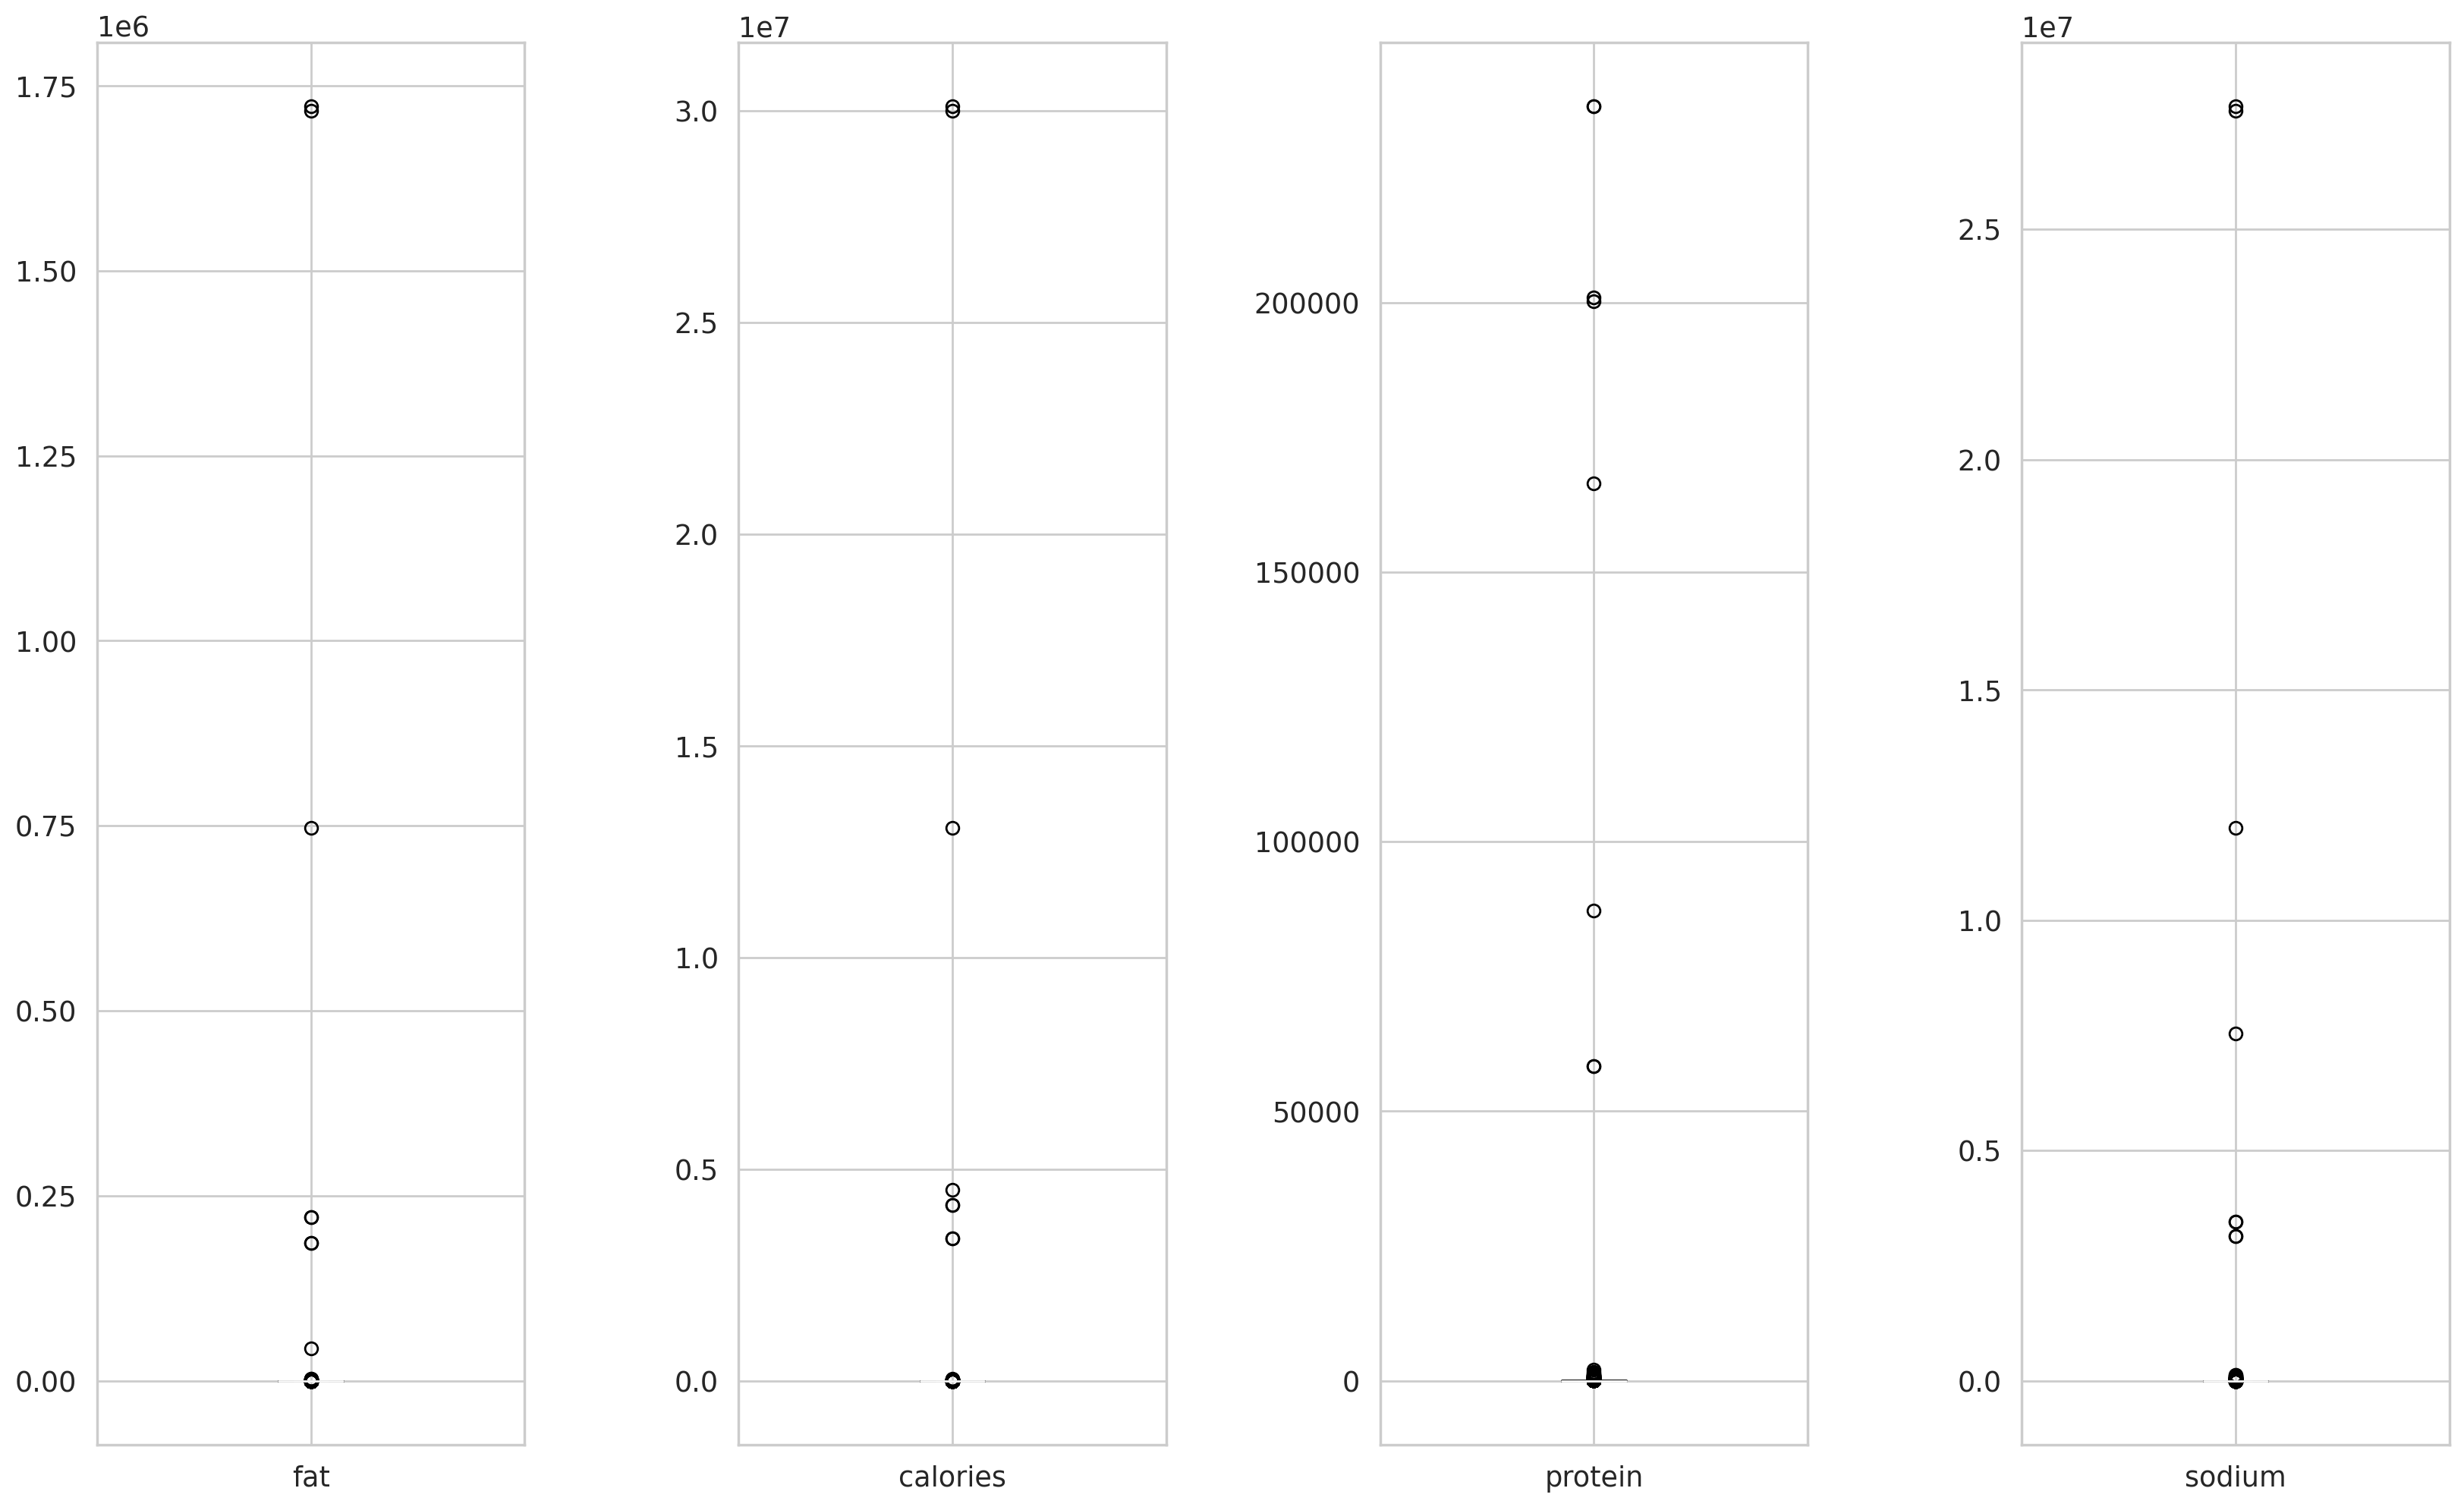

In [20]:
multicolumnsBoxplot(df_numVar[subset_column])

Após a análise do outliers, pode-se percebe que existe um grande número de valores discrepantes nas colunas ['fat','calories','protein','sodium']. Assim o próximo passo é excluir esses valores discrepantes.

 #### Excluindo os outliers

In [21]:
print('df_numVar before removing outliers \nshape: ', df_numVar.shape)

df_numVar before removing outliers 
shape:  (14390, 5)


In [22]:
# removing the lines with outliers in ['fat','calories','protein','sodium']
 
for name in subset_column:
  print("-----",name,"-----")
  column = df_numVar[name]
  df_numVar = drop_outliers_IQR(df_numVar, column)  
  outliers = find_outliers_IQR(df_numVar[name])
  showBasicOutliersInfo(df_numVar, outliers)



----- fat -----
outliers value
amount:  397
max value:  75.0
min value:  65.0
median value: 70.0

df main median:  18.0
----- calories -----
outliers value
amount:  97
max value:  1055.0
min value:  1008.0
median value: 1031.0

df main median:  331.0
----- protein -----
outliers value
amount:  614
max value:  51.0
min value:  42.0
median value: 46.0

df main median:  8.0
----- sodium -----
outliers value
amount:  312
max value:  1405.0
min value:  1216.0
median value: 1298.0

df main median:  248.0


In [23]:
print('df_numVar after removing outliers \nshape: ', df_numVar.shape)

df_numVar after removing outliers 
shape:  (11642, 5)


Após excluir os outliers identificado anteriormente, o dataset passou de **14_390** para **11_642**. É observado que ainda existem uma grande quantidade de valores discrepantes, no entanto, os dados que restaram são coerentes, considerando o contexto dos quais foram extraidos.

Para obter uma visualização melhor desses dados, podemos apresenta-los por meio de um boxplot.

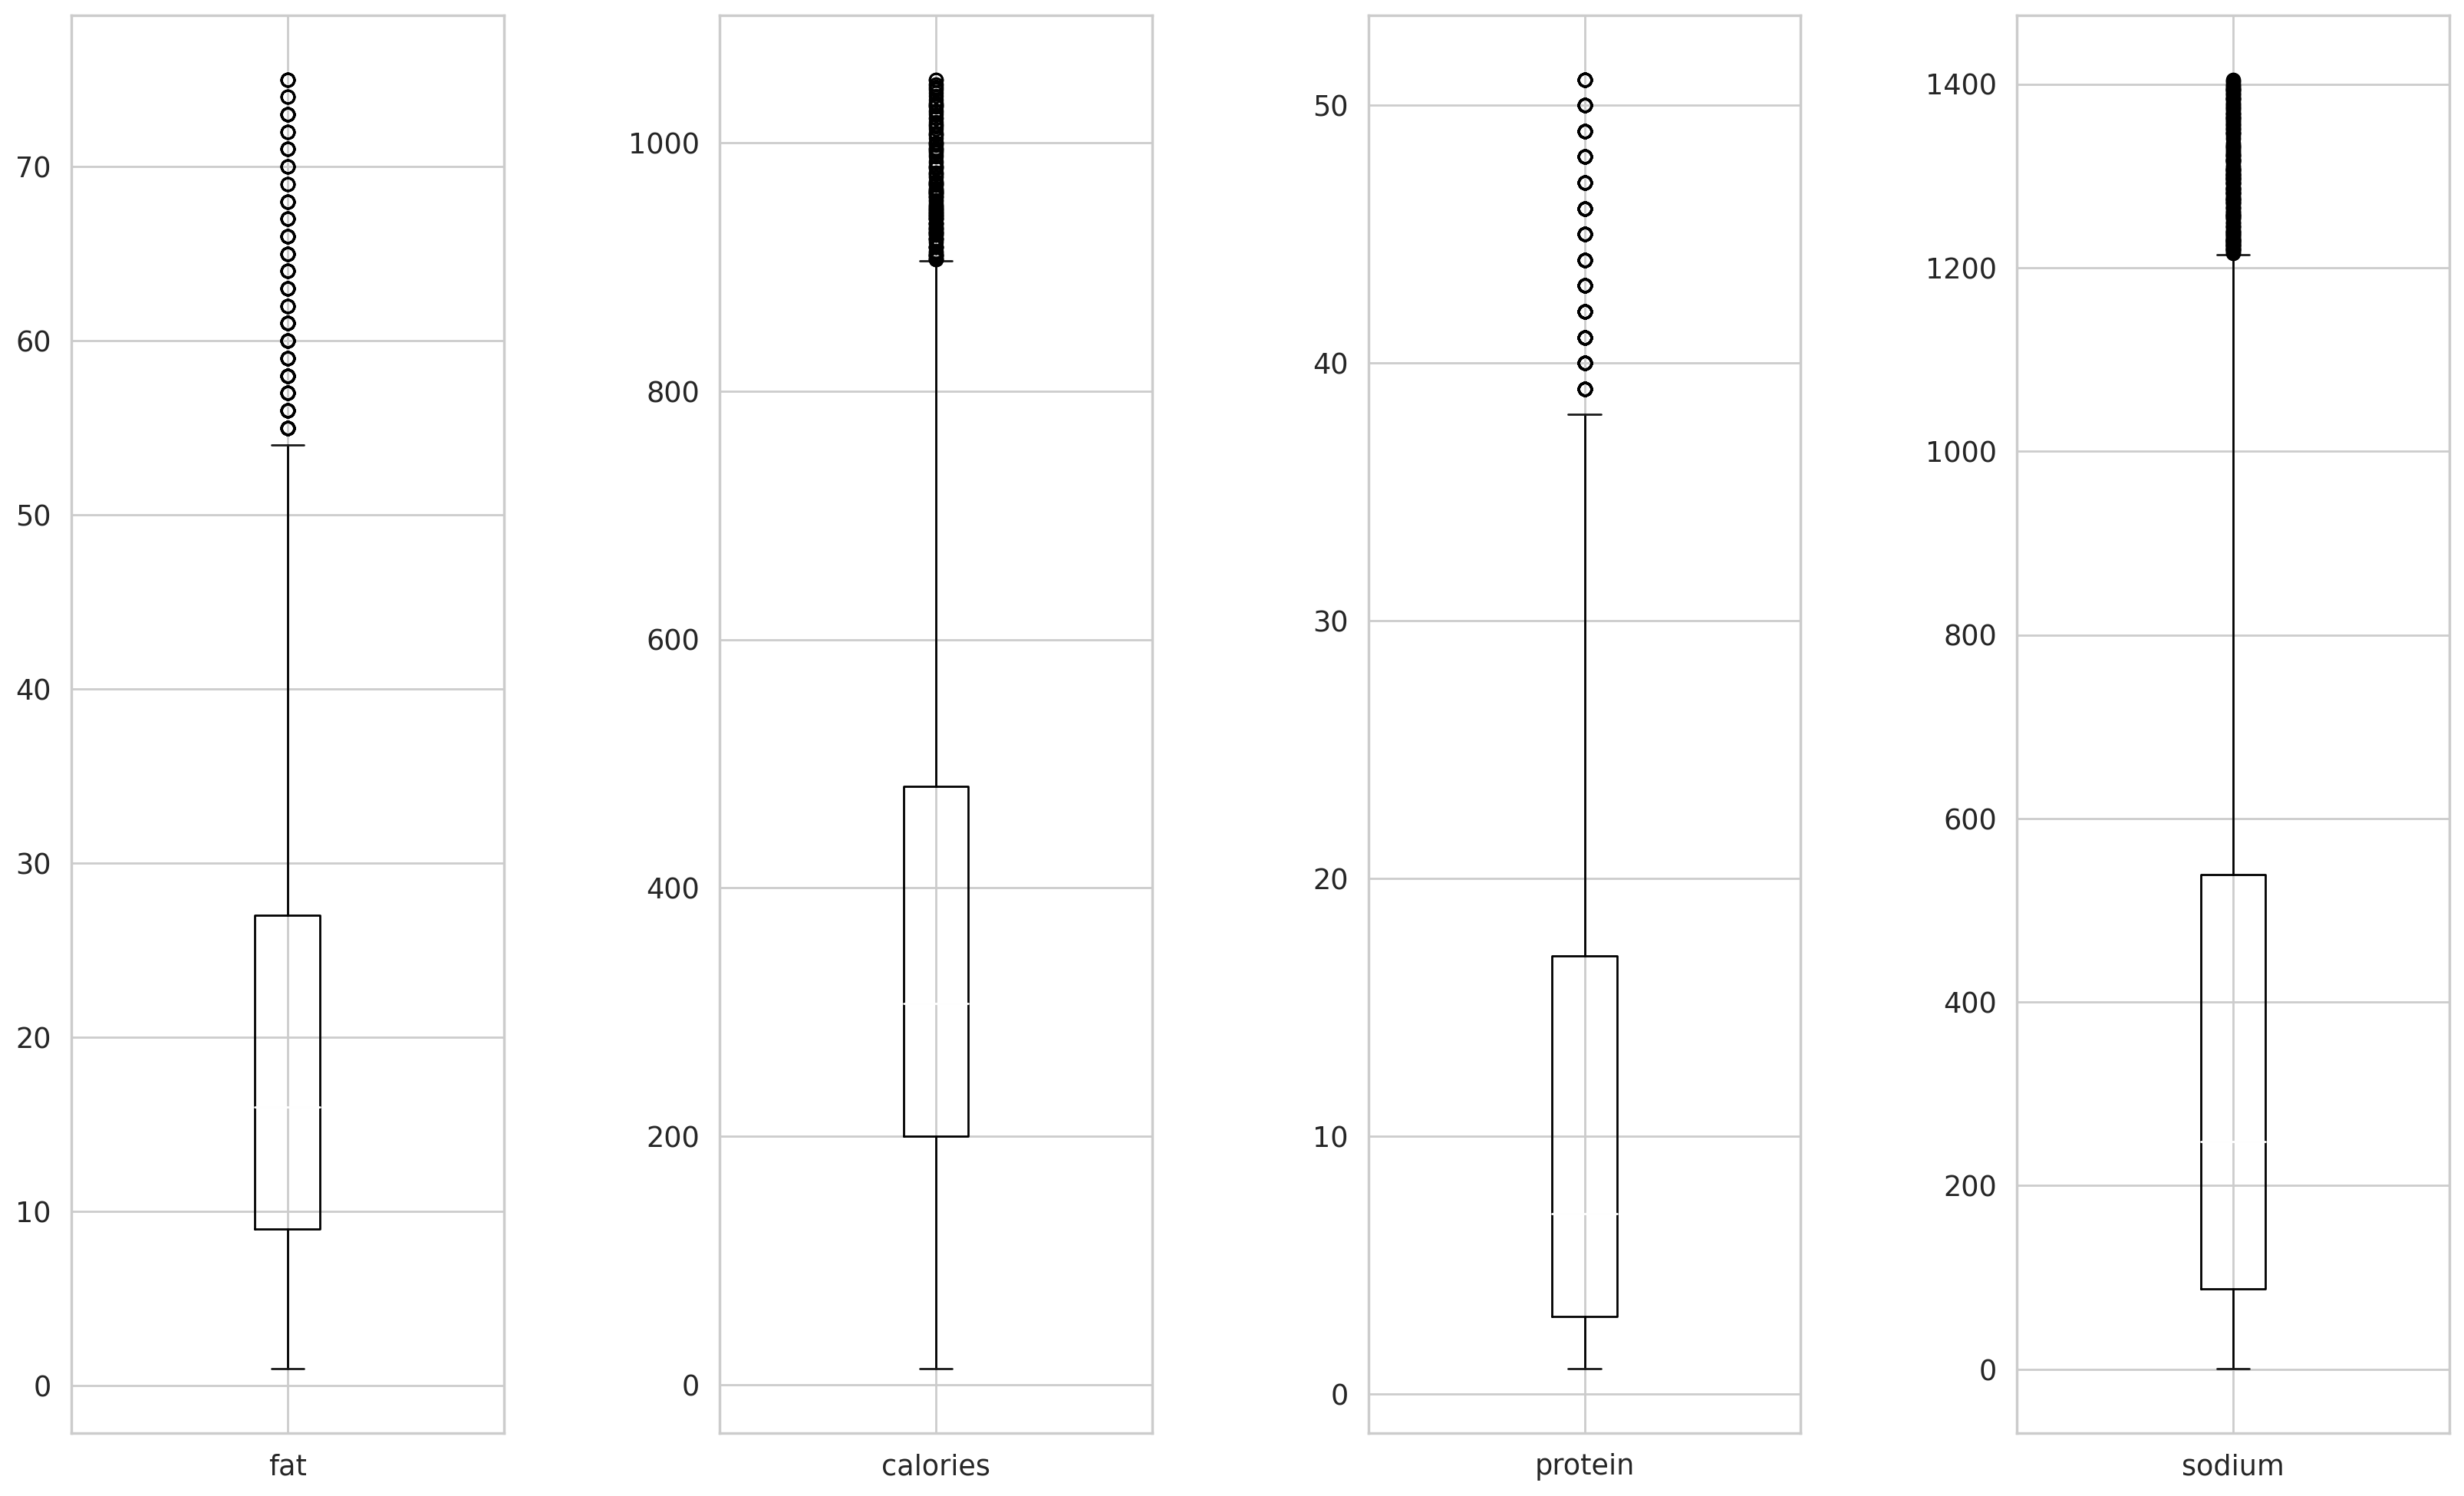

In [25]:
multicolumnsBoxplot(df_numVar[subset_column])

<AxesSubplot:>

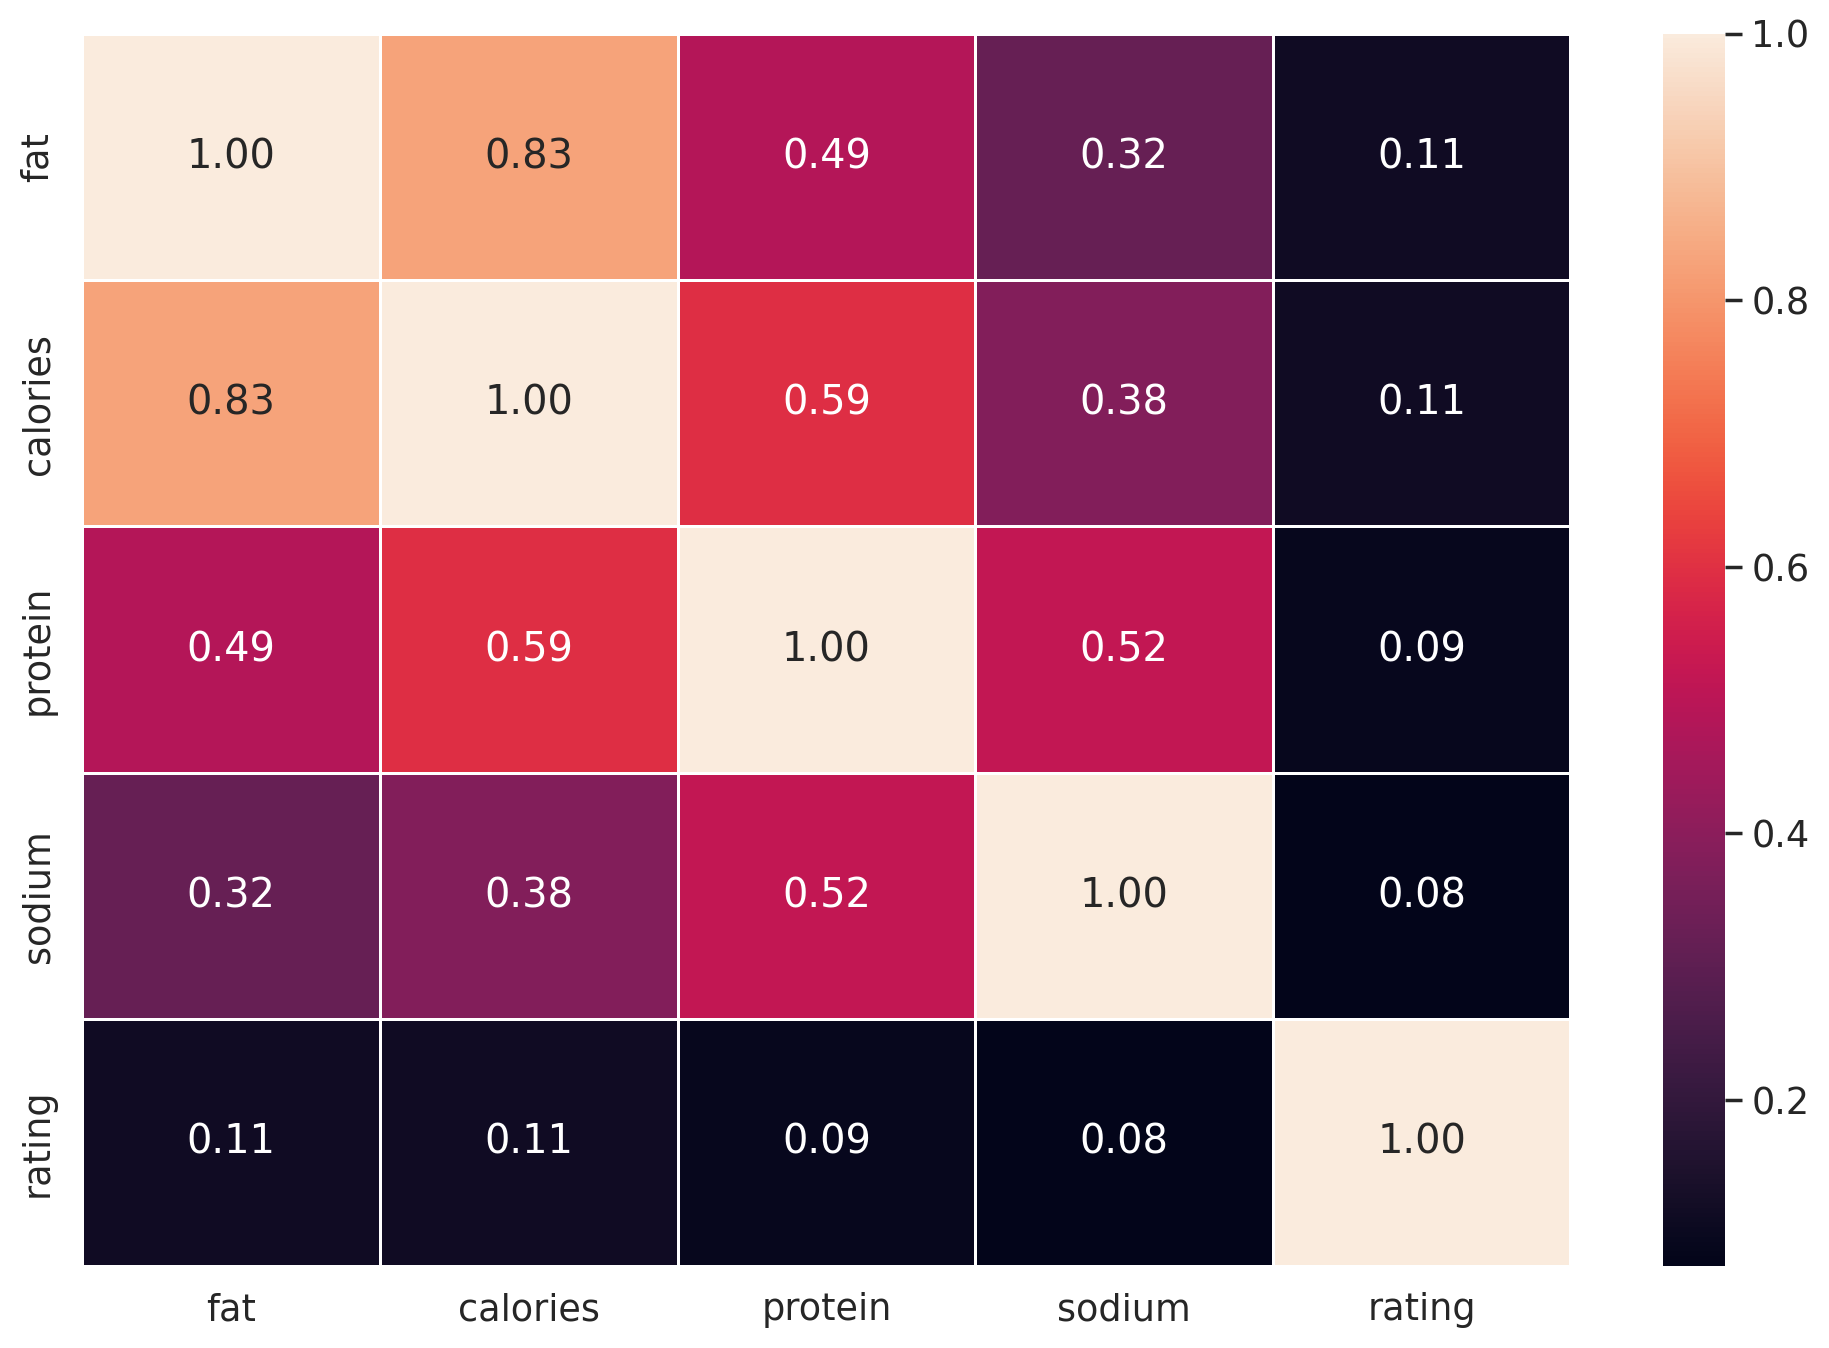

In [24]:
correlation = df_numVar.corr()
plot = sns.heatmap(correlation, annot = True, fmt=".2f", linewidths=.4)
plot

A correlação mais forte é identificada entre as variáveis **fat** e **calories**. Em relação as demais variáveis, é possível identificar que a variável **sódium** está mais relacionada com a variável **protein**, do que com as demais variáveis.

Provavelmente a relação maior entre variável **sodium** com a variável **protein**, está associada ao fato que a maiorias das receitas que envolvem ingredientes protéicos recebem quantidades maiores de sal.



### Trabalhando com as variáveis categóricas

Nesta seção vamos iniciar a analisar a popularidade do site de receitas ao longo dos anos e o engajamento dos usuários desse site. Para isso vamos fazer um análise do número de receitas registradas por ano, e o número médio das avaliações realizadas pelos usuários em cada ano.

Posteriormente, será realizado a análise referente as categorias das receitas, com o objetivo idenficar em qual das categorias existe o maior número de receitas e identificar também se existe a predominância de alguma categoria em anos consecutivos.



#### Analisando a popularidade das receitas por ano

Para iniciar nossa análise vamos definir um novo dataframe, a partir do dataframe original(sem as linhas NaN), contendo apenas as variáveis **date** e **rating**

In [25]:
#df_catVar = df[df.columns[~df.columns.isin(subset_numericCols)]]
df_popularity = df[['date', 'rating']]
df_popularity['date'] = pd.to_datetime(df_popularity['date'])

print('shape:',df_popularity.shape)
df_popularity.head(3)

shape: (20111, 2)


/tmp/ipykernel_8554/1272287953.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_popularity['date'] = pd.to_datetime(df_popularity['date'])


,date,rating
0,2006-09-01 04:00:00+00:00,2.500
1,2004-08-20 04:00:00+00:00,4.375
2,2004-08-20 04:00:00+00:00,3.750


In [26]:
popularity_by_year = pd.DataFrame()

popularity_by_year['n_recipes'] = df_popularity.groupby(df_popularity['date'].dt.year).count()['rating']
popularity_by_year.head()

,n_recipes
date,
1996,1
1998,3
1999,4
2003,5
2004,11576


In [27]:
df_popularity = df_popularity.loc[(df_popularity['rating']>0)]
popularity_by_year['recipes_with_votes'] = df_popularity.groupby(df_popularity['date'].dt.year).count()['rating']
popularity_by_year['mean_rating'] = df_popularity.groupby(df_popularity['date'].dt.year).mean()['rating']
popularity_by_year

/tmp/ipykernel_8554/24625601.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  popularity_by_year['mean_rating'] = df_popularity.groupby(df_popularity['date'].dt.year).mean()['rating']


,n_recipes,recipes_with_votes,mean_rating
date,,,
1996,1,NaN,NaN
1998,3,3.0,4.166667
1999,4,4.0,4.062500
2003,5,3.0,3.750000
2004,11576,10908.0,4.016204
2005,661,635.0,4.122047
2006,1376,1307.0,4.113428
2007,1030,986.0,4.141734
2008,666,635.0,4.267717


In [28]:
popularity_by_year.fillna(0,inplace=True)
#popularity_by_year.replace(np.nan, 0)

In [29]:
popularity_by_year

,n_recipes,recipes_with_votes,mean_rating
date,,,
1996,1,0.0,0.000000
1998,3,3.0,4.166667
1999,4,4.0,4.062500
2003,5,3.0,3.750000
2004,11576,10908.0,4.016204
2005,661,635.0,4.122047
2006,1376,1307.0,4.113428
2007,1030,986.0,4.141734
2008,666,635.0,4.267717


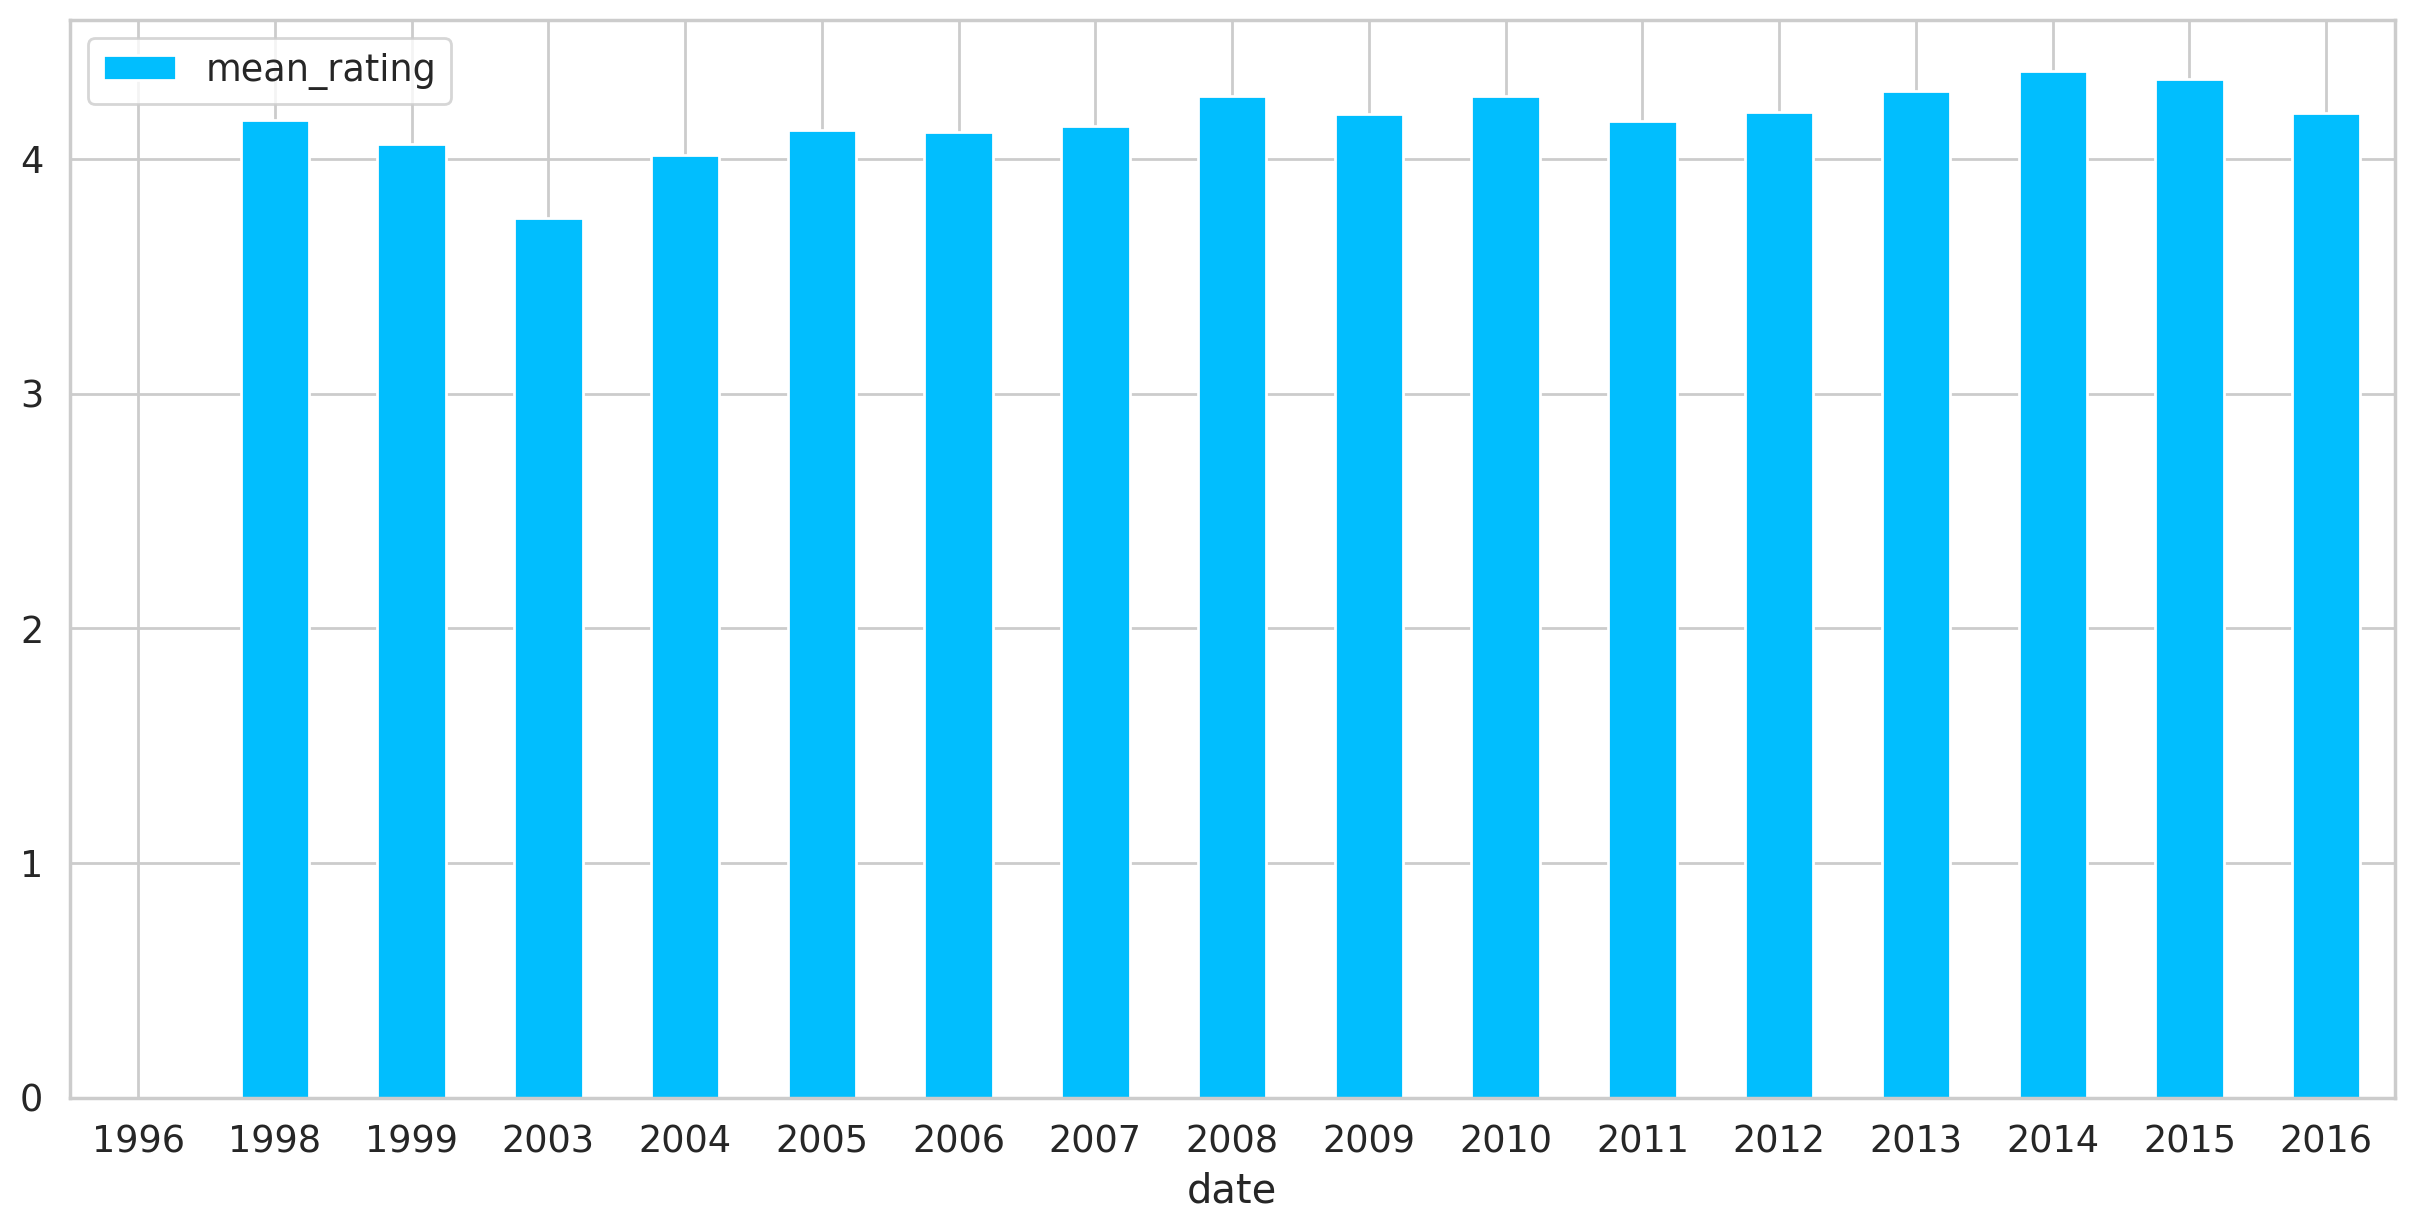

In [43]:
popularity_by_year.plot.bar(y='mean_rating', rot=0, figsize=(15,7));
#sns.barplot(recipesByYear['date'],x)

#### Verificando possíveis dados duplicados referente ao ano **2004**

In [33]:
frequency_values  = df['title'].value_counts(dropna=False)


In [34]:
frequency_values.head(15)

Pastry Dough            28
Chicken Stock           26
Turkey Giblet Stock     20
Turkey Stock            15
Simple Syrup            15
Pizza Dough             11
Salsa Verde             11
Tomatillo Salsa         10
Pickled Red Onions       9
White Fish Stock         9
Vegetable Stock          8
Corn Bread               8
French 75                7
Horseradish Cream        7
Avocado Salsa            7
Name: title, dtype: int64

In [35]:
df_Y2004 = df[df['date'].str.contains("2004")]
df_Y2004_title = df_Y2004['title'].value_counts(dropna=False)

#df_pastry = df[df['title'].str.contains("Pastry Dough")]
#df_Y2004.shape

df_Y2004_title


Chicken Stock                                               20
Pastry Dough                                                18
Turkey Giblet Stock                                         14
Turkey Stock                                                 9
Corn Bread                                                   8
                                                            ..
Filets Mignons with Creamy Paprika Sauce                     1
Carrot and Beet Salad with Ginger Vinaigrette                1
Strawberry and Banana Tartlets in Coconut Pastry Shells      1
Lemon Margarita                                              1
Baked Ham with Marmalade-Horseradish Glaze                   1
Name: title, Length: 10298, dtype: int64

#### Analisando a variável *categories*

Vamos dar uma olhada na coluna **categories**.

In [36]:
lista_categorias=[] 
for itens_categoria in df['categories']:
  lista_categorias.append(itens_categoria)

In [37]:
#cria lista com todos os itens
itens=[]
def insertItems(l):
  for i in l:
    if isinstance(i,list):
      insertItems(i)
    else:
      itens.append(i) 
  return

In [40]:
insertItems(lista_categorias)
itens=list(set(itens))    
itens = [element for element in itens if str(element) != "nan"]   
#print(itens)

In [41]:
len(itens)

674

In [42]:
df=df.explode('categories').reset_index(drop=True)
df.head()

,directions,fat,date,categories,calories,desc,protein,rating,title,ingredients,sodium
0,"[1. Place the stock, lentils, celery, carrot, ...",7.0,2006-09-01T04:00:00.000Z,Sandwich,426.0,None,30.0,2.5,"Lentil, Apple, and Turkey Wrap","[4 cups low-sodium vegetable or chicken stock,...",559.0
1,"[1. Place the stock, lentils, celery, carrot, ...",7.0,2006-09-01T04:00:00.000Z,Bean,426.0,None,30.0,2.5,"Lentil, Apple, and Turkey Wrap","[4 cups low-sodium vegetable or chicken stock,...",559.0
2,"[1. Place the stock, lentils, celery, carrot, ...",7.0,2006-09-01T04:00:00.000Z,Fruit,426.0,None,30.0,2.5,"Lentil, Apple, and Turkey Wrap","[4 cups low-sodium vegetable or chicken stock,...",559.0
3,"[1. Place the stock, lentils, celery, carrot, ...",7.0,2006-09-01T04:00:00.000Z,Tomato,426.0,None,30.0,2.5,"Lentil, Apple, and Turkey Wrap","[4 cups low-sodium vegetable or chicken stock,...",559.0
4,"[1. Place the stock, lentils, celery, carrot, ...",7.0,2006-09-01T04:00:00.000Z,turkey,426.0,None,30.0,2.5,"Lentil, Apple, and Turkey Wrap","[4 cups low-sodium vegetable or chicken stock,...",559.0


Desejo investigar as categorias 'LOW'

In [43]:
itens_low = list(filter(lambda x : re.search(r'.{0}Low \S', x) ,itens))
print(itens_low)

['Low Cholesterol', 'Low Sodium', 'Low Cal', 'Low Fat', 'Low Sugar', 'Low Carb']


In [44]:
itens_low = itens_low +  list(filter(lambda x : re.search(r'.{0}Low\S', x) ,itens))
print(itens_low)

['Low Cholesterol', 'Low Sodium', 'Low Cal', 'Low Fat', 'Low Sugar', 'Low Carb', 'Low/No Sugar']


In [45]:
new_df=df.loc[(df['categories'] == 'Low Carb') | (df['categories'] == 'Low/No Sugar') | (df['categories'] =='Low Sodium') | (df['categories'] =='Low Fat')| (df['categories'] =='low cal')| (df['categories'] =='Low Sugar')|(df['categories'] =='Low Sodium') | (df['categories'] =='Low Fat')| (df['categories'] =='low cal')| (df['categories'] =='Low Cholesterol')]
new_df=new_df[['categories','fat','calories','protein','sodium']]
new_df

,categories,fat,calories,protein,sodium
33,Low Fat,NaN,NaN,NaN,NaN
71,Low Fat,NaN,NaN,NaN,NaN
162,Low Carb,12.0,174.0,11.0,176.0
216,Low Carb,7.0,107.0,5.0,344.0
247,Low Fat,NaN,NaN,NaN,NaN
...,...,...,...,...,...
244089,Low Cholesterol,2.0,120.0,3.0,3339.0
244386,Low/No Sugar,23.0,216.0,1.0,5.0
244411,Low Carb,95.0,1168.0,74.0,131.0
244426,Low Fat,0.0,16.0,0.0,2292.0


In [47]:
# CLASS DISTRIBUTIONlow
#if dataset is balanced or not
x=new_df['categories'].value_counts()
print(x)
#sns.barplot(x.index,x)

Low Fat            929
Low Cholesterol    445
Low Sodium         389
Low Carb           363
Low/No Sugar       282
Low Sugar           14
Name: categories, dtype: int64


Outra forma de analisar dados numéricos seria usar box plots. O box plot nos mostra a mediana dos dados, que representa onde está o ponto de dados do meio. Os quartis superior e inferior representam os percentis 75 e 25 dos dados, respectivamente. Os extremos superior e inferior nos mostram os extremos da distribuição de nossos dados. Por fim, também representa outliers, que ocorrem fora dos extremos superior e inferior.

### Manipulando outliers e valores ausentes


As colunas numéricas contém dados faltantes. Podemos lidar com valores ausentes de várias maneiras:

* Excluir: podemos excluir as linhas com os valores ausentes ou excluir toda a coluna com valores ausentes. O método dropna() da biblioteca Pandas pode ser usado para realizar esta tarefa.
* Imputar: A exclusão de dados pode causar uma grande quantidade de perda de informações. Portanto, substituir dados pode ser uma opção melhor do que excluir. Uma técnica de substituição padrão é substituir os valores ausentes pelo valor médio da coluna inteira. Por exemplo, podemos substituir os valores ausentes na coluna "fat" pelo valor médio da coluna "fat". O método fillna() da biblioteca Pandas pode ser usado para realizar esta tarefa.
* Preenchimento preditivo: Como alternativa, podemos optar por preencher os valores ausentes por meio do preenchimento preditivo. O método interpolate() realizará uma interpolação linear para “adivinhar” os valores ausentes e preencher os resultados no conjunto de dados.

---



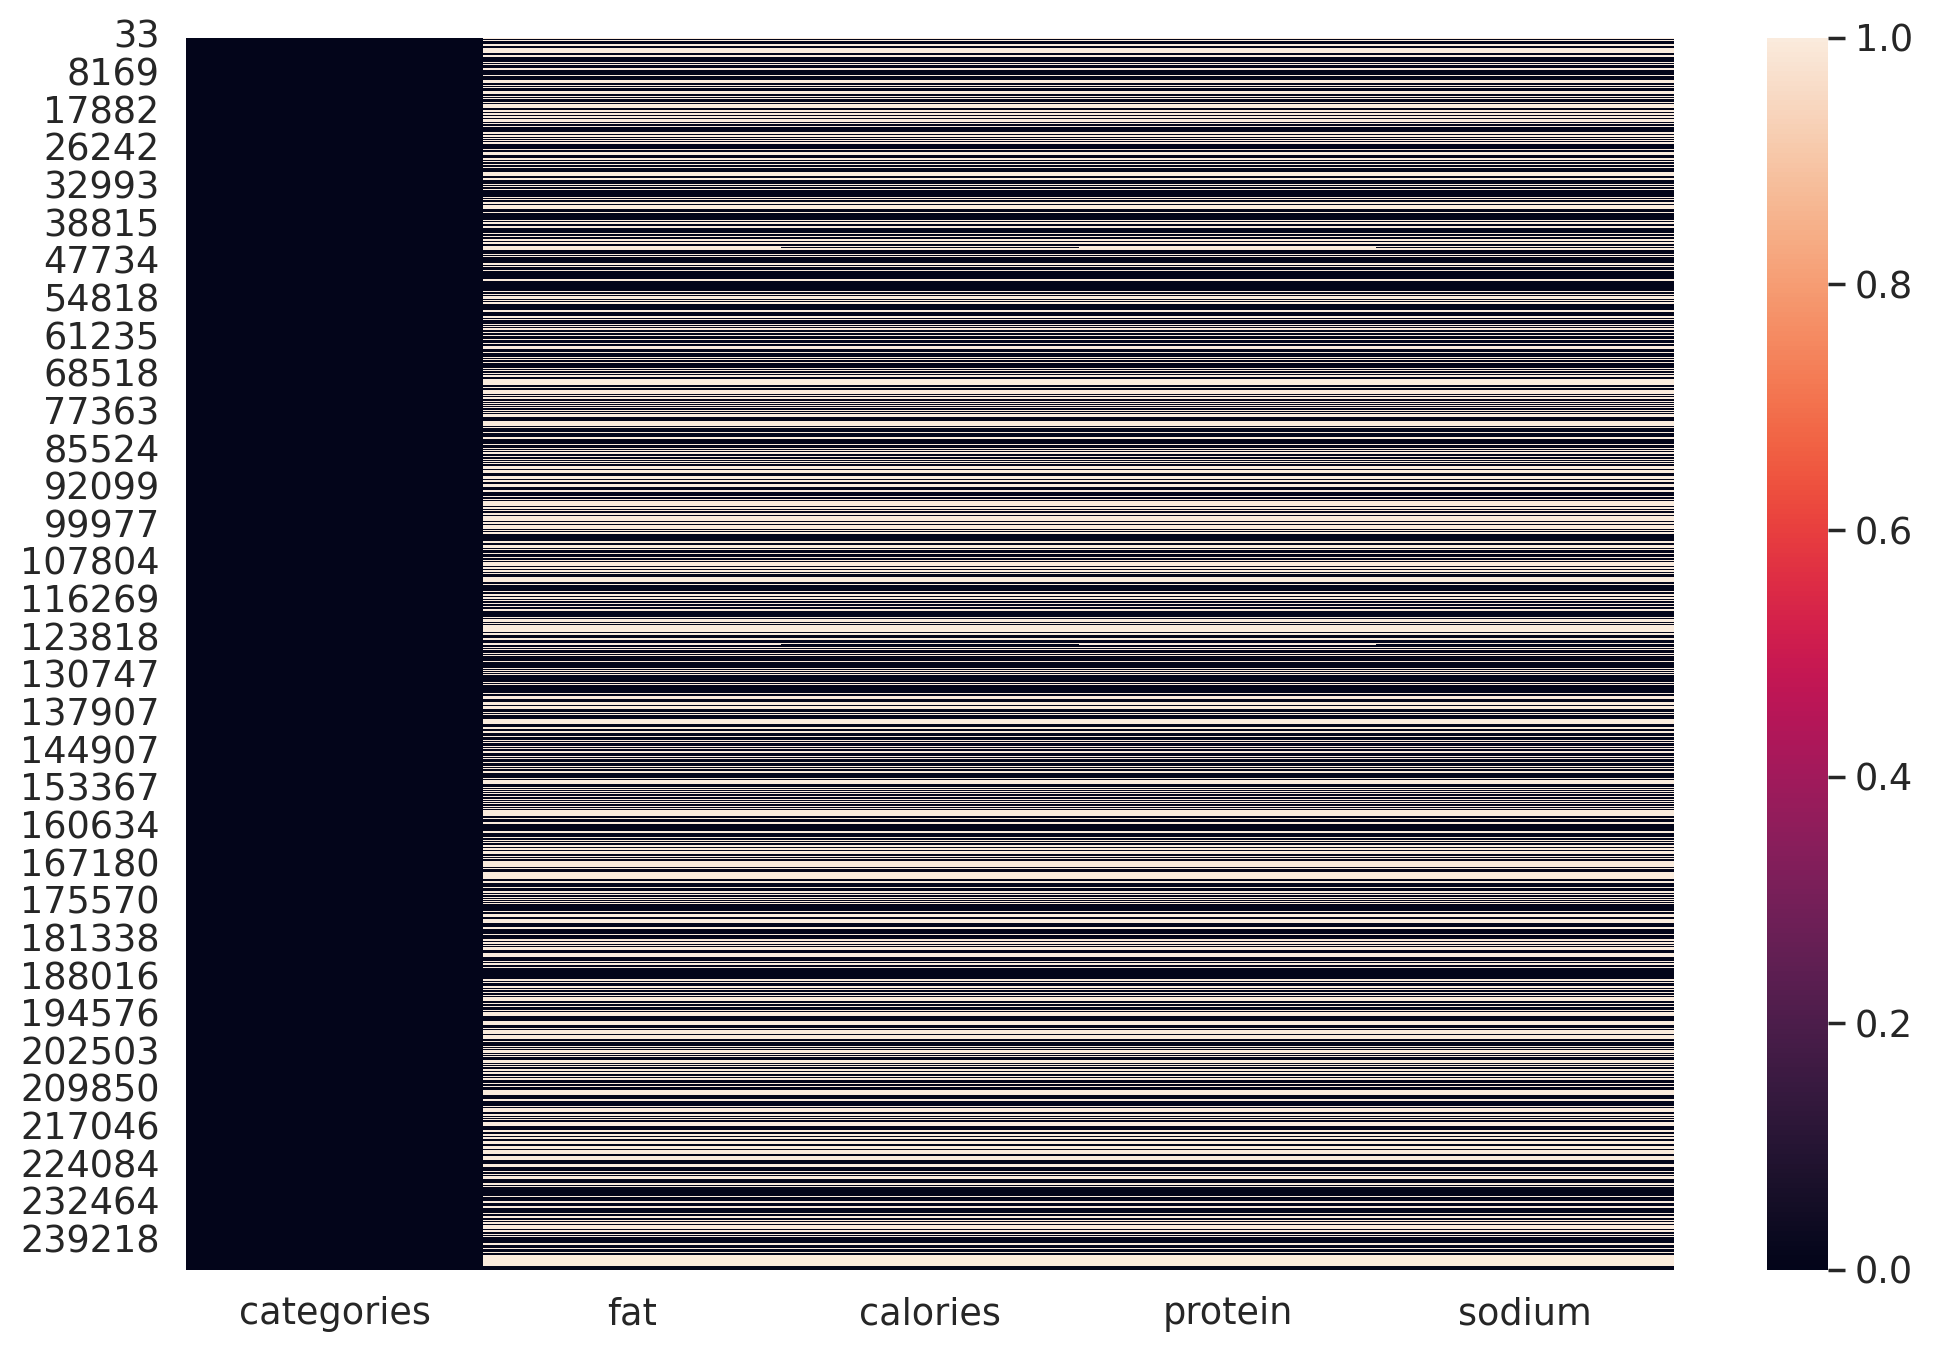

In [48]:
sns.heatmap(new_df.isnull())
plt.show()

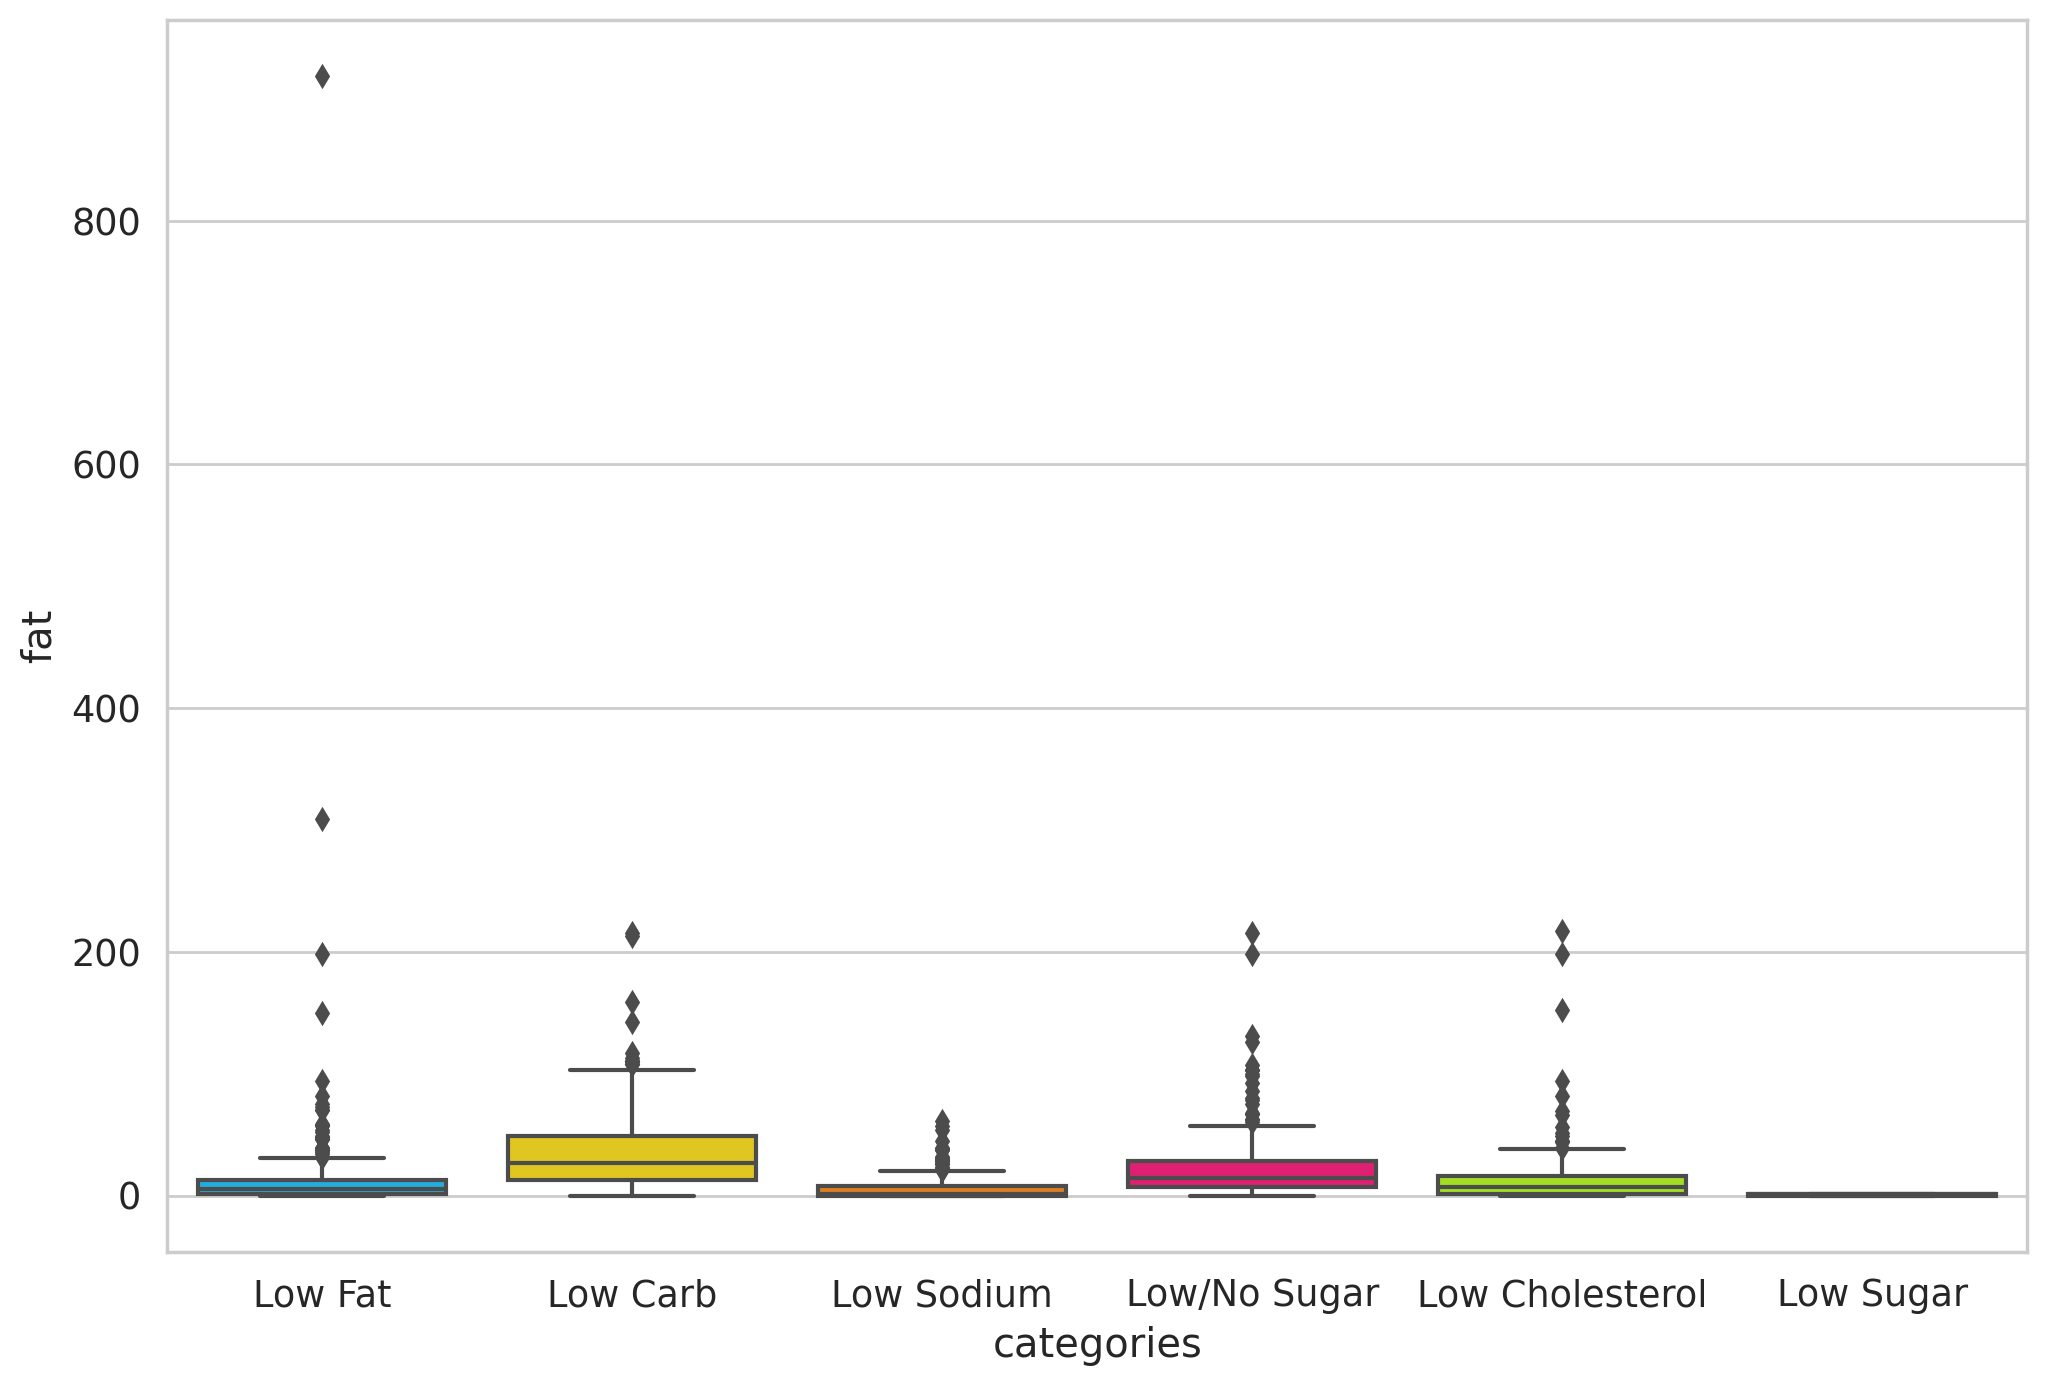

In [49]:
sns.boxplot(x='categories',y='fat',data=new_df);

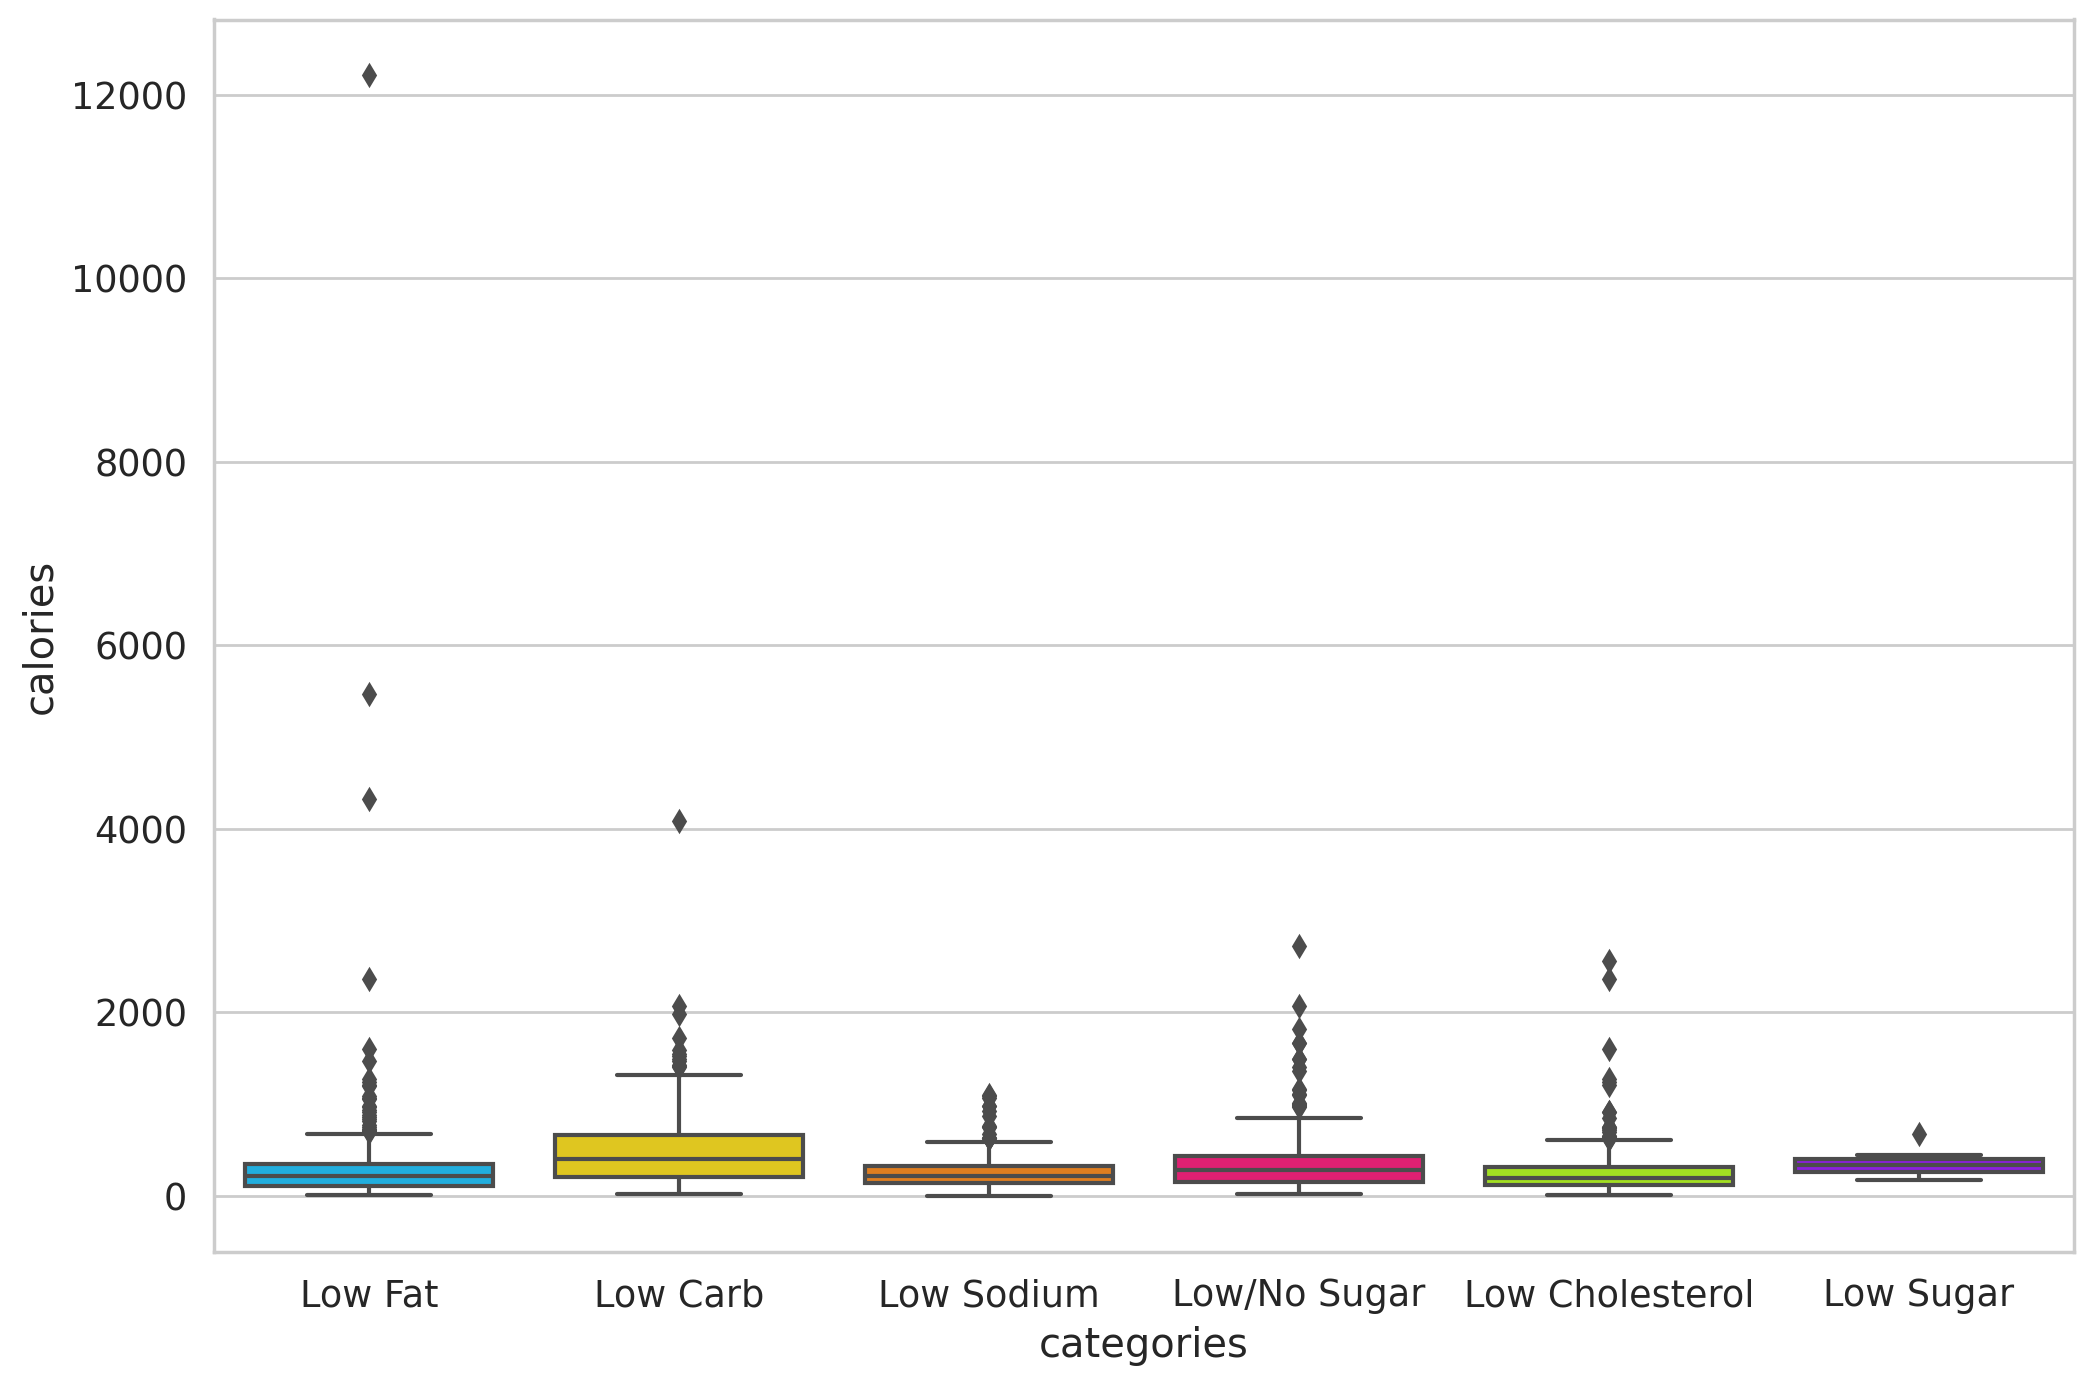

In [50]:
sns.boxplot(x='categories',y='calories',data=new_df);

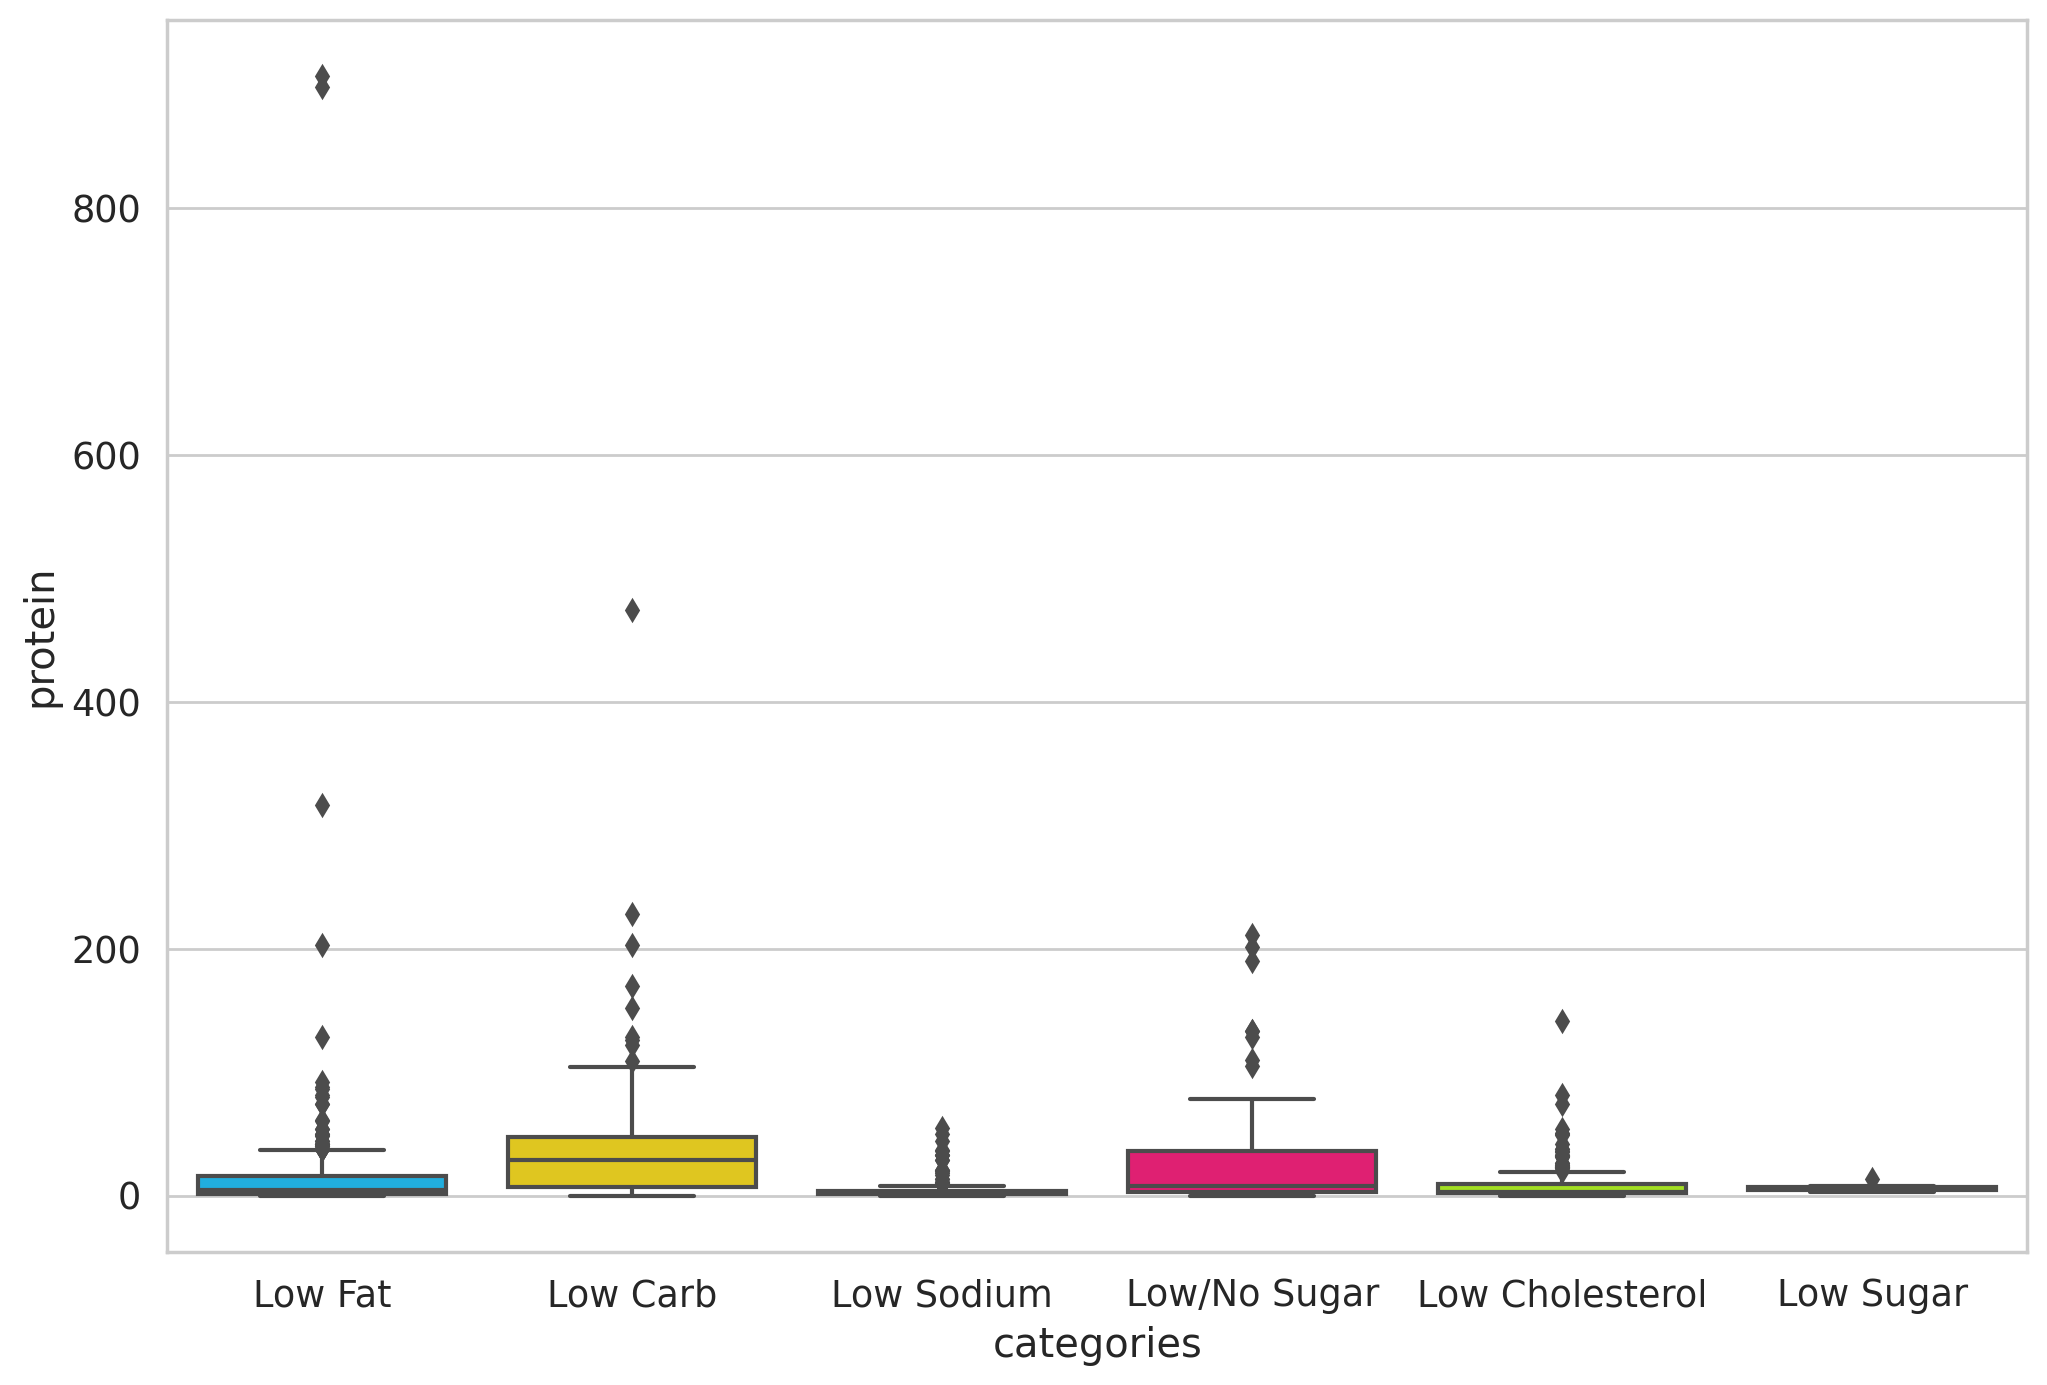

In [51]:
sns.boxplot(x='categories',y='protein',data=new_df);

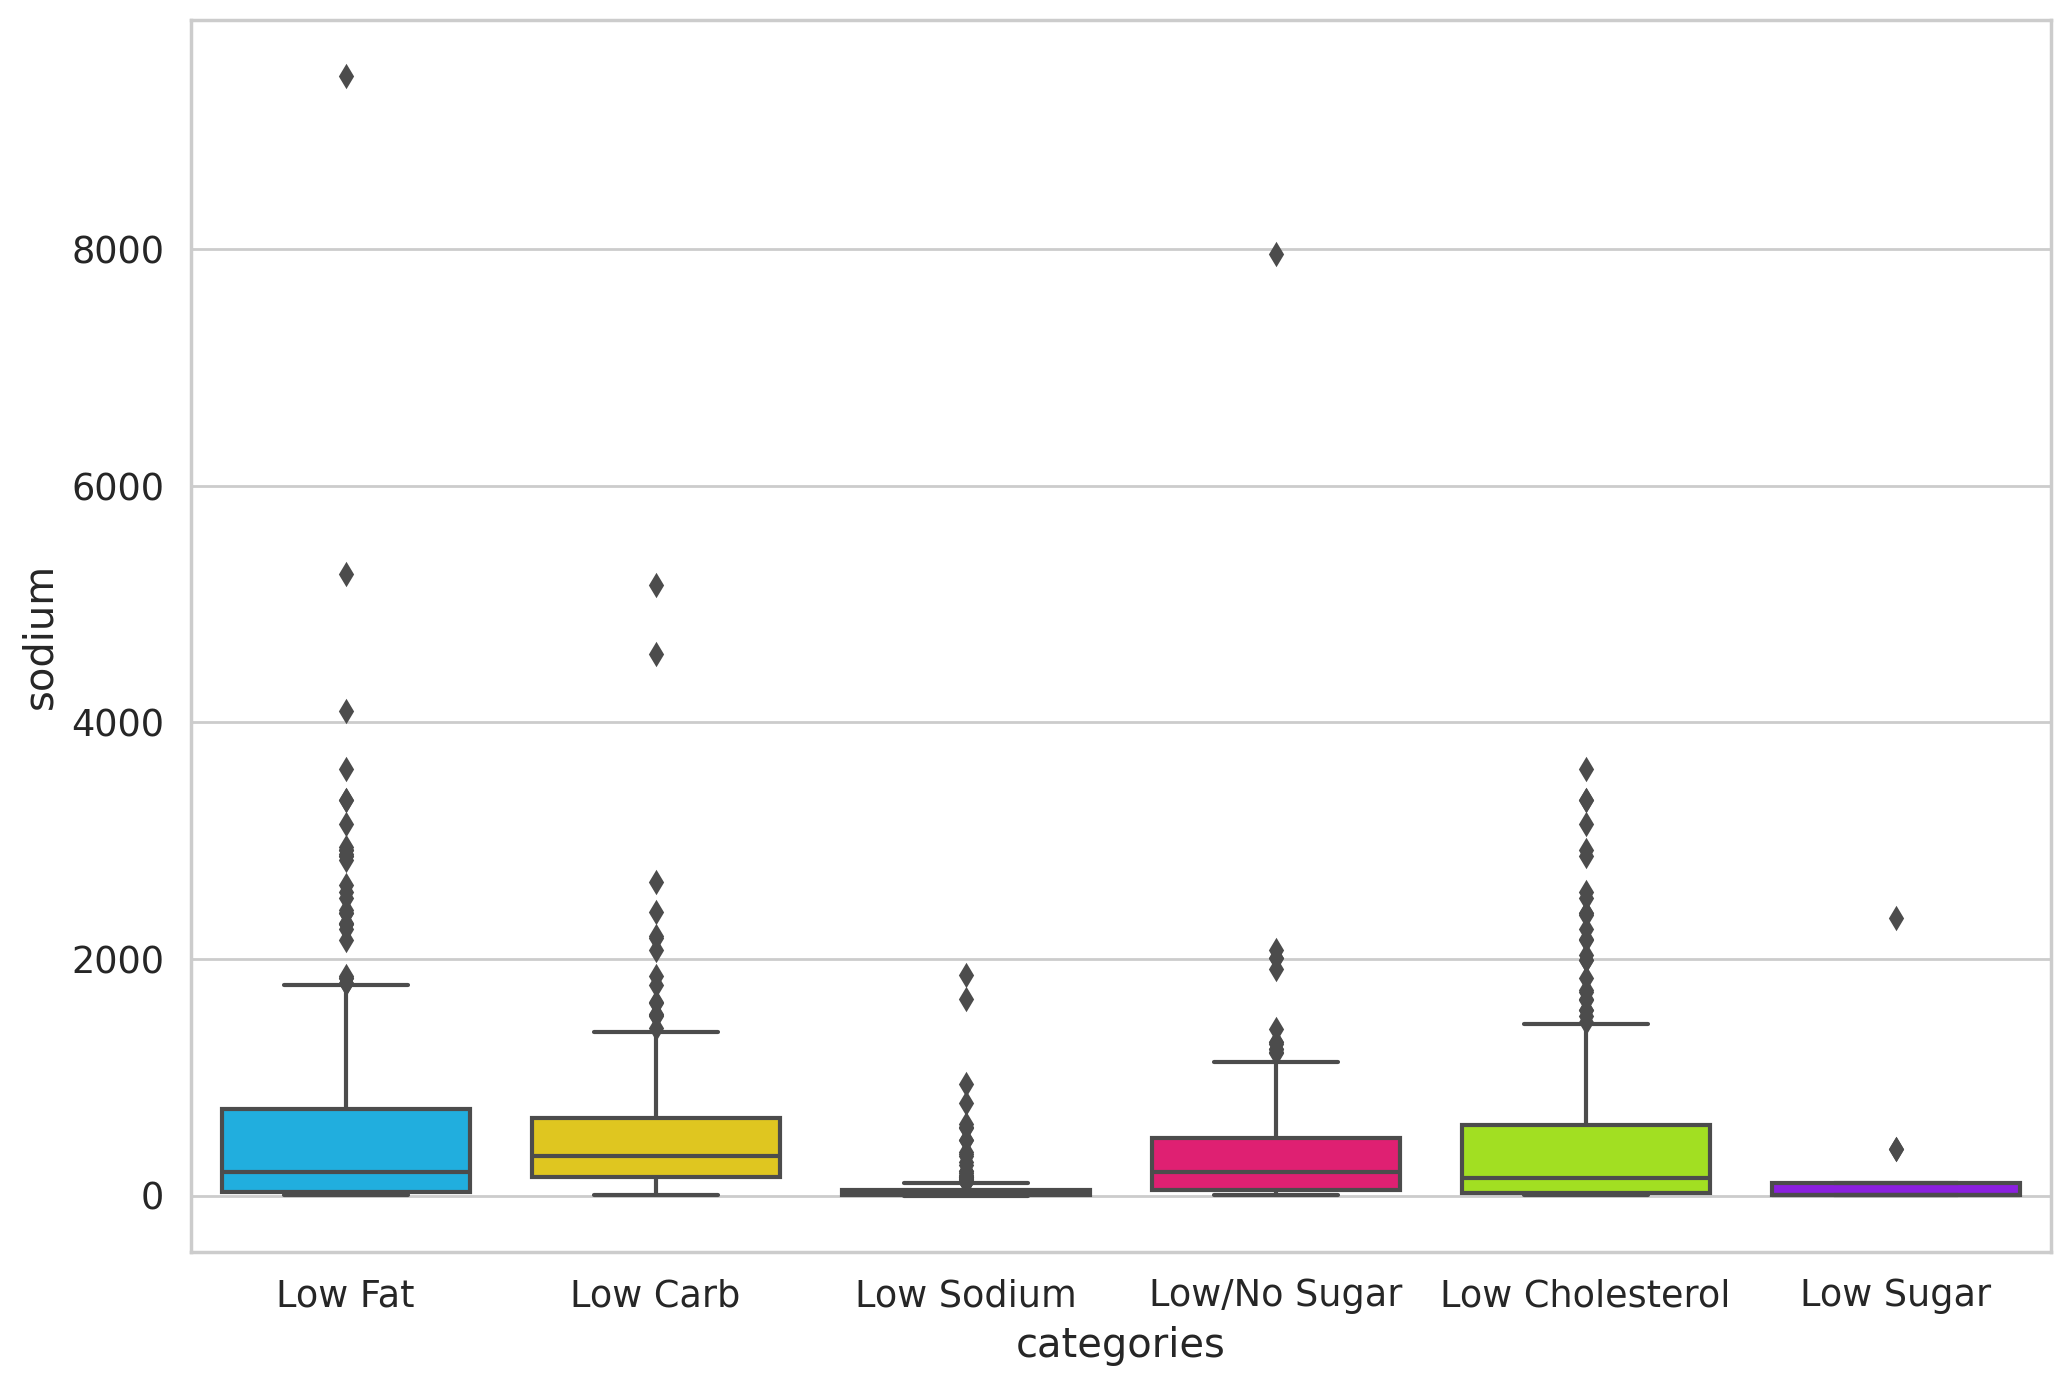

In [52]:
sns.boxplot(x='categories',y='sodium',data=new_df);

Pelo gráfico acima vemos outliers da coluna 'fat' com o vamos acima de 100, justamente para uma refeição da categoria "Low Fat". Vamos tratá-los.

In [53]:
print('fat>100: ',new_df.loc[(new_df['fat']>100)].shape,'\n')
print('fat<=100: ',new_df.loc[(new_df['fat']<=100)].shape,'\n')
print('calories>2000: ',new_df.loc[(new_df['calories']>2000)].shape,'\n')
print('calories<=2000: ',new_df.loc[(new_df['calories']<=2000)].shape,'\n')
print('protein>200: ',new_df.loc[(new_df['protein']>200)].shape,'\n')
print('protein<=200: ',new_df.loc[(new_df['protein']<=200)].shape,'\n')
print('sodium>200: ',new_df.loc[(new_df['protein']>200)].shape,'\n')
print('protein<=200: ',new_df.loc[(new_df['protein']<=200)].shape,'\n')

fat>100:  (30, 5) 

fat<=100:  (1339, 5) 

calories>2000:  (10, 5) 

calories<=2000:  (1364, 5) 

protein>200:  (9, 5) 

protein<=200:  (1361, 5) 

sodium>200:  (9, 5) 

protein<=200:  (1361, 5) 



Primeiro calculamos os outliers em df["fat"] como matrizes booleanas separadas (com o mesmo comprimento da série original).

In [54]:
outlier = np.where(new_df["fat"] >= 100,1,0).astype(bool)
is_null = np.where(new_df["fat"].isnull(),1,0).astype(bool)
impute = (outlier | is_null)

In [55]:
new_df["impute"] = impute

In [56]:
#novo vetor de features para os valores que usaremos para imputar. 
#Este é um subconjunto de 'fat' dependendo se foi sinalizado como um valor atípico ou ausente.
fat_=np.where(~impute, new_df.fat, np.nan)
new_df["fat"] = fat_

#### Imputação pela mediana

In [57]:
#Vou imputar os valores usando preprocessing.Imputer do scikit-learn.
median_imputer = SimpleImputer(missing_values=np.nan,strategy="median")
fat_complete = median_imputer.fit_transform(fat_.reshape(-1, 1))
new_df["fat"] = fat_complete

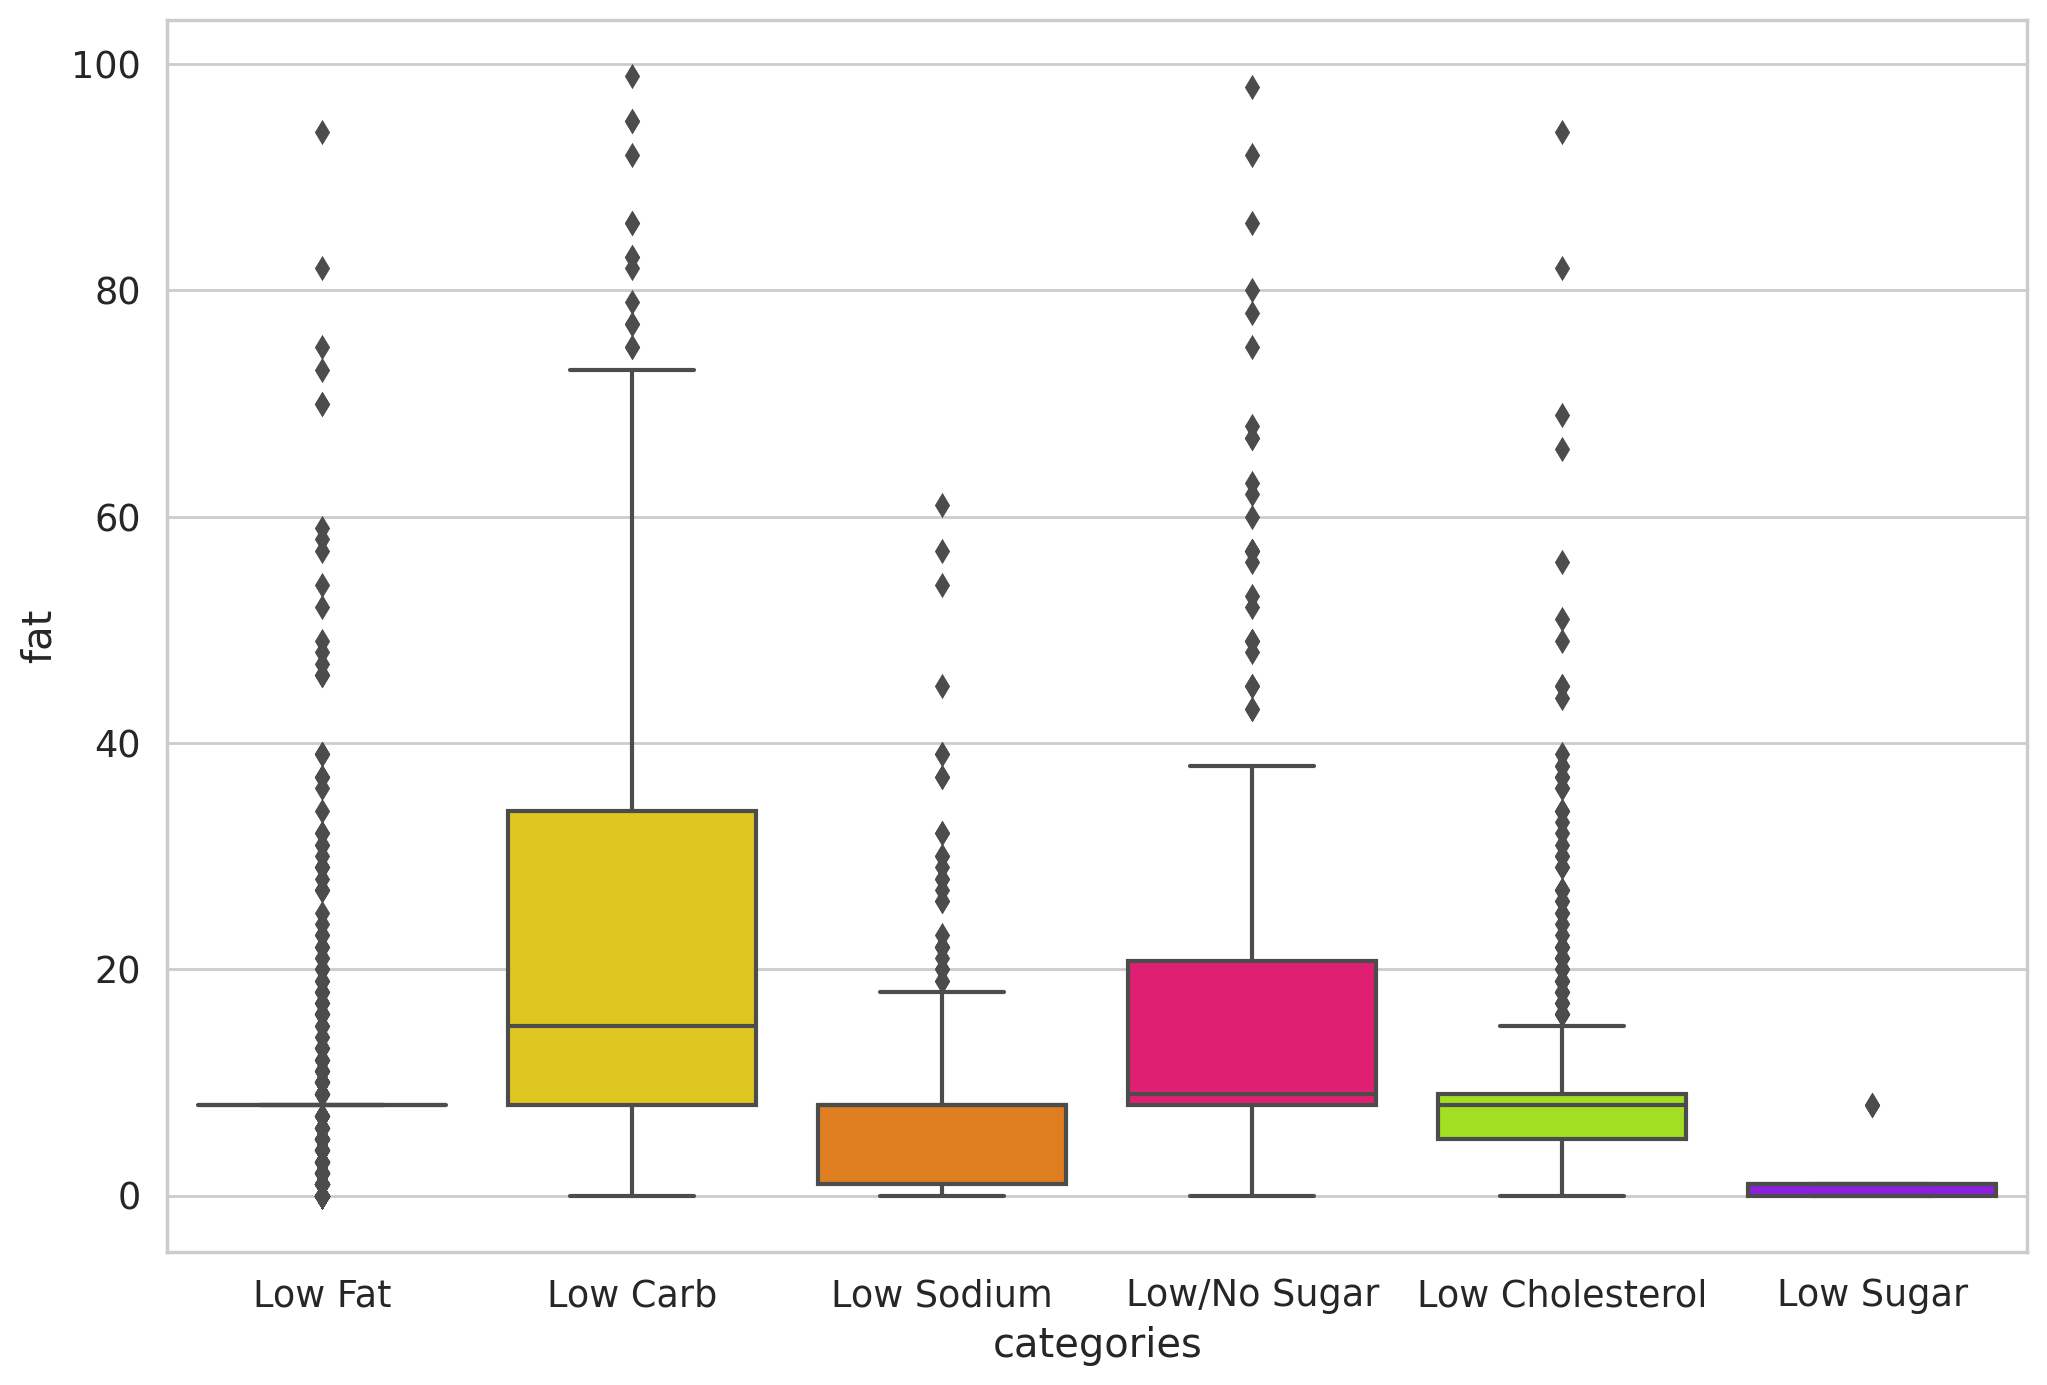

In [58]:
sns.boxplot(x='categories',y='fat',data=new_df);

In [59]:
low_fat.head()

NameError: name 'low_fat' is not defined

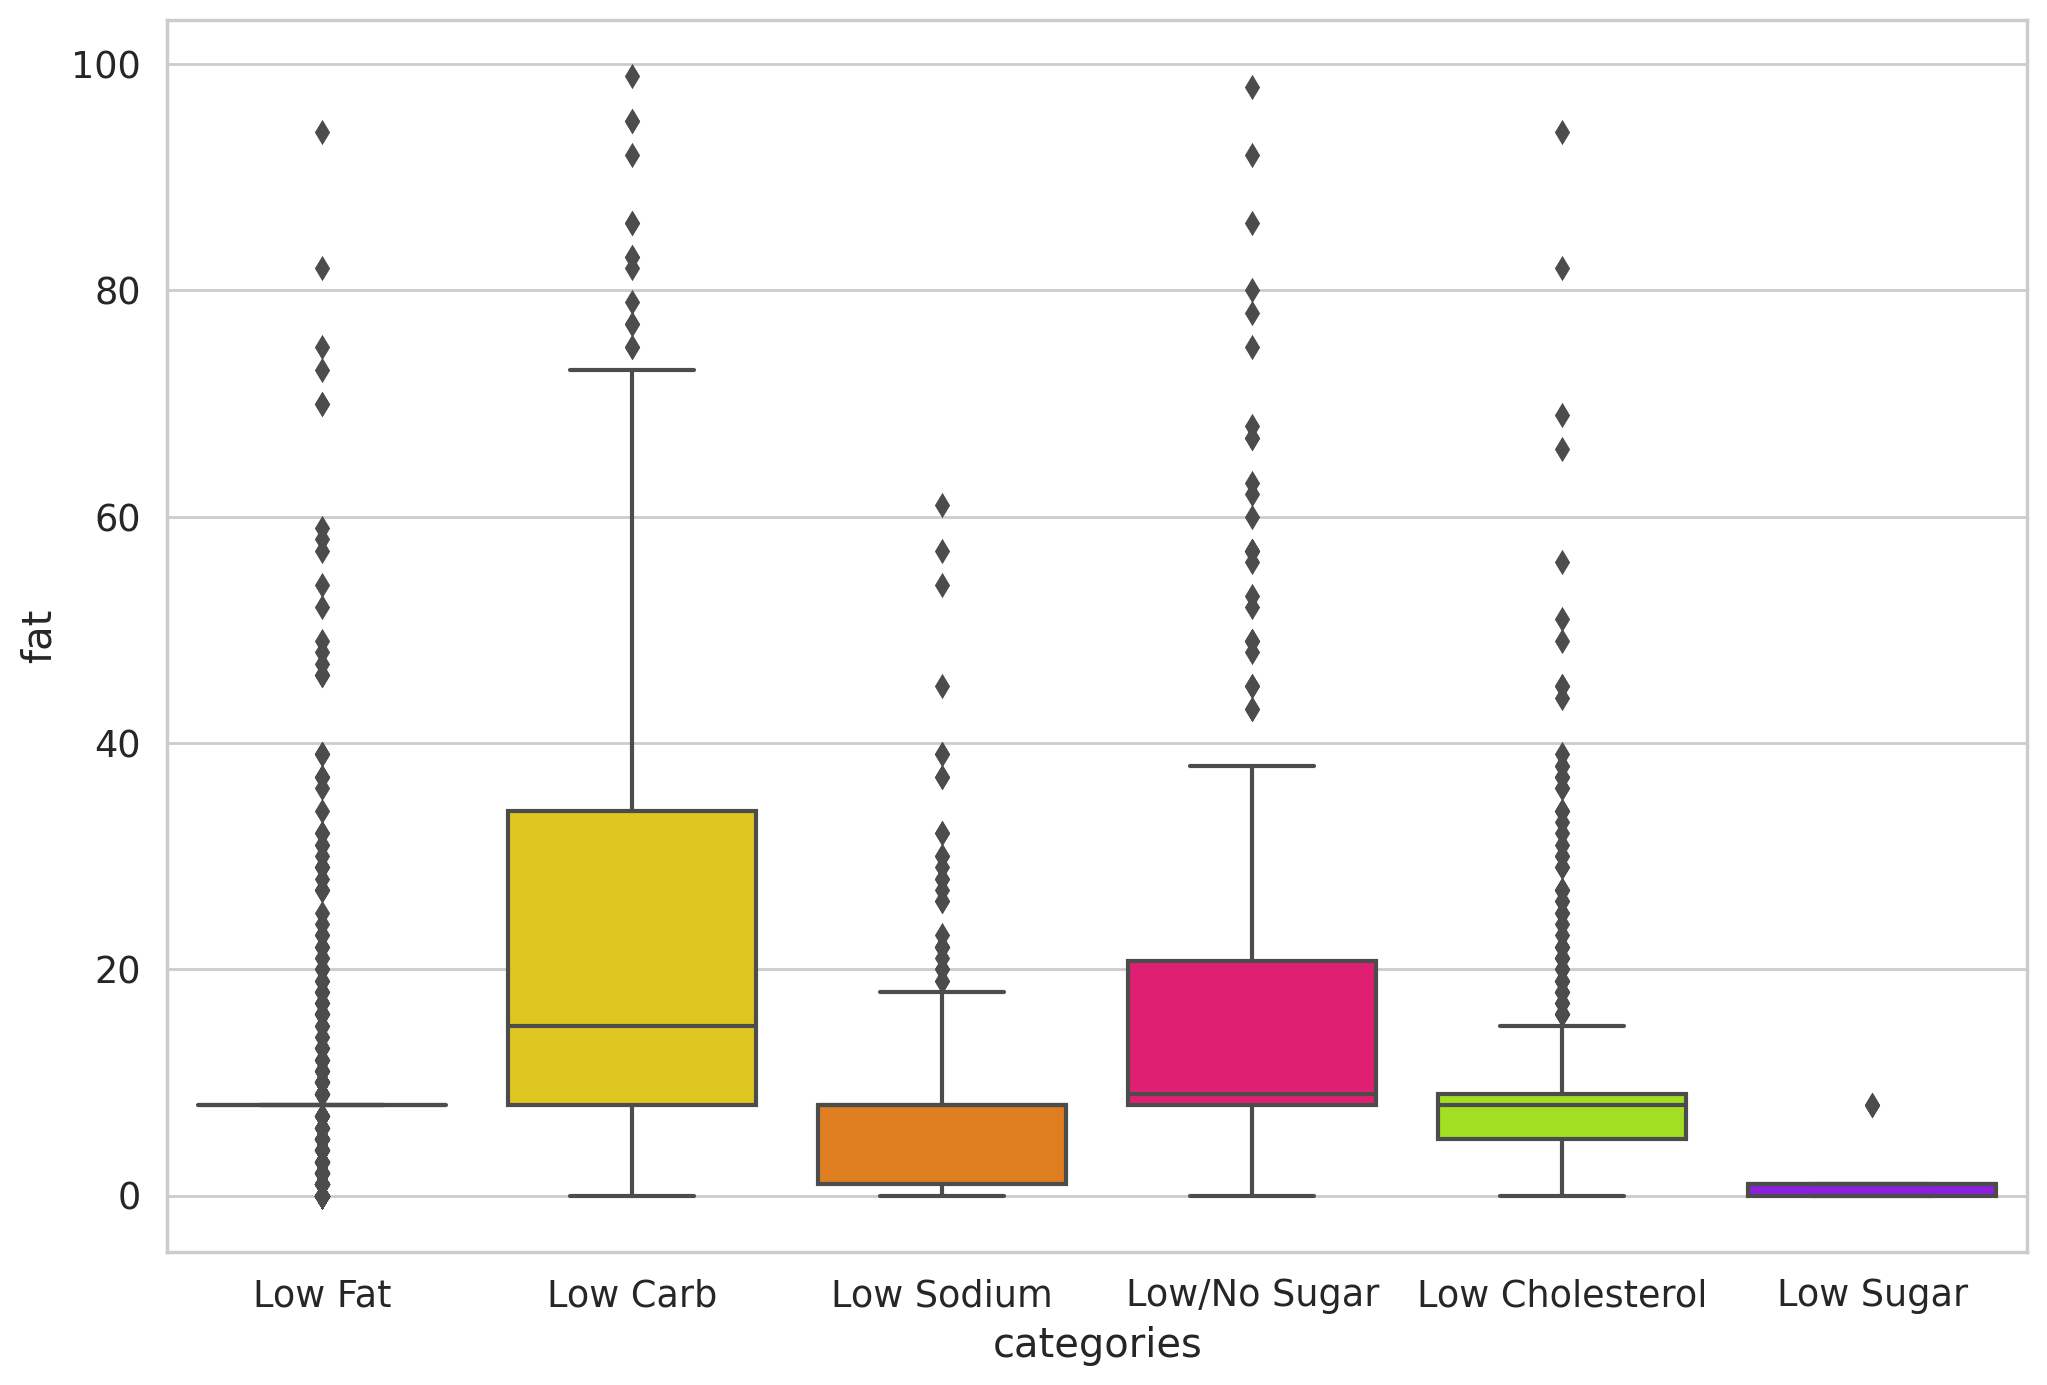

In [60]:
sns.boxplot(x='categories',y='fat',data=new_df);

In [61]:
#new_df_x= new_df[[ 'title','categories', 'fat', 'calories', 'protein',  'sodium']]

KeyError: "['title'] not in index"

Importancia das *features*